# KAGGLE SANTANDER COMPETITION

https://www.kaggle.com/c/santander-customer-transaction-prediction#description

## SHORT PROBLEM STATEMENT

- In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 
- The data provided for this competition has the same structure as the real data we have available to solve this problem.
- Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## TO-DO LIST

- Try to blend different approaches in optimized way (Bayesian optimization):
    * Gaussian Naive Bayes
    * XGB boosted tree
    * Anomaly detection (with Autoencoder approach)
- Use autoencoder to compress input features.

# IMPORTS

In [1]:
# Standard boiler plate imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os 
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import time
import random
import csv
import json

#SKLEARN imports
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, PolynomialFeatures, QuantileTransformer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

#from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Activation, Input, Lambda
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import regularizers
import keras.backend as K
import keras_metrics
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [2]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import rand, tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [3]:
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 50)         # Keep the output on one page

In [5]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# LOAD DATA

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print('Data loaded.')

Data loaded.


In [7]:
sample_submission.head()

ID_code  target
0  test_0       0
1  test_1       0
2  test_2       0
3  test_3       0
4  test_4       0

In [ ]:
train.shape

# DATA EXPLORATION

In [11]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   var_8   var_9  var_10   var_11   var_12   var_13  var_14  \
0  18.6266 -4.9200  5.7470  2.9252   3.1821  14.0137   0.5745  8.7989   
1  16.5338  3.1468  8.0851 -0.4032   8.0585  14.0239   8.4135  5.4345   
2  14.6155 -4.9193  5.9525 -0.3249 -11.2648  14.1929   7.3124  7.5244   
3  14.9250 -5.8609  8.2450  2.3061   2.8102  13.8463  11.9704  6.4569   
4  19.2514  6.2654  7.6784 -9.4458 -12.1419  13.8481   7.8895  7.7894   

    var_15   var_16   var_17   var_18   var_19   var_20   var_21   var_22  \
0  14.5691   5.7487  -7.2393   4.2840  30.7133  10.5350  16.2191   2.5791   
1  13.7003  13.8275 -15.5849   7.8000  28.5708   3.4287   2.7407   8.5524   
2  14.6472   7.6782  -1.7395   4.7011  20.4775  17.7559  18.1377   1.2145   
3  14.8372  10.7430  -0.4299  15.9426  13.7257  20.3010  12.5579   6.8202   
4  15.0553   8.4871  -3.0680   6.5263  11.3152  21.4246  18.9608  10.1102   

   var_23   var_24   var_25   var_26  var_27  var_28  var_29   var_30  \
0  2.4716  14.3831  13.4325  -5.1488 -0.4073  4.9306  5.9965  -0.3085   
1  3.3716   6.9779  13.8910 -11.7684 -2.5586  5.0464  0.5481  -9.2987   
2  3.5137   5.6777  13.2177  -7.9940 -2.9029  5.8463  6.1439 -11.1025   
3  2.7229  12.1354  13.7367   0.8135 -0.9059  5.9070  2.8407 -15.2398   
4  2.7142  14.2080  13.5433   3.1736 -3.3423  5.9015  7.9352  -3.1582   

    var_31  var_32   var_33   var_34   var_35  var_36  var_37   var_38  \
0  12.9041 -3.8766  16.8911  11.1920  10.5785  0.6764  7.8871   4.6667   
1   7.8755  1.2859  19.3710  11.3702   0.7399  2.7995  5.8434  10.8160   
2  12.4858 -2.2871  19.0422  11.0449   4.1087  4.6974  6.9346  10.8917   
3  10.4407 -2.5731   6.1796  10.6093  -5.9158  8.1723  2.8521   9.1738   
4   9.4668 -0.0083  19.3239  12.4057   0.6329  2.7922  5.8184  19.3038   

   var_39   var_40   var_41   var_42   var_43   var_44   var_45   var_46  \
0  3.8743  -5.2387   7.3746  11.5767  12.0446  11.6418  -7.0170   5.9226   
1  3.6783 -11.1147   1.8730   9.8775  11.7842   1.2444 -47.3797   7.3718   
2  0.9003 -13.5174   2.2439  11.5283  12.0406   4.1006  -7.9078  11.1405   
3  0.6665  -3.8294  -1.0370  11.7770  11.2834   8.0485 -24.6840  12.7404   
4  1.4450  -5.5963  14.0685  11.9171  11.5111   6.9087 -65.4863  13.8657   

    var_47   var_48   var_49   var_50   var_51  var_52  var_53  var_54  \
0 -14.2136  16.0283   5.3253  12.9194  29.0460 -0.6940  5.1736 -0.7474   
1   0.1948  34.4014  25.7037  11.8343  13.2256 -4.1083  6.6885 -8.0946   
2  -5.7864  20.7477   6.8874  12.9143  19.5856  0.7268  6.4059  9.3124   
3 -35.1659   0.7613   8.3838  12.6832   9.5503  1.7895  5.2091  8.0913   
4   0.0444  -0.1346  14.4268  13.3273  10.4857 -1.4367  5.7555 -8.5414   

    var_55   var_56  var_57  var_58   var_59   var_60   var_61  var_62  \
0  14.8322  11.2668  5.3822  2.0183  10.1166  16.1828   4.9590  2.0771   
1  18.5995  19.3219  7.0118  1.9210   8.8682   8.0109  -7.2417  1.7944   
2   6.2846  15.6372  5.8200  1.1000   9.1854  12.5963 -10.3734  0.8748   
3  12.3972  14.4698  6.5850  3.3164   9.4638  15.7820 -25.0222  3.4418   
4  14.1482  16.9840  6.1812  1.9548   9.2048   8.6591 -27.7439 -0.4952   

   var_63  var_64  var_65  var_66   var_67  var_68  var_69   var_70  var_71  \
0 -0.2154  8.6748  9.5319  5.8056  22.4321  5.0109 -4.7010  21.6374  0.5663   
1 -1.3147  8.1042  1.5365  5.4007   7.9344  5.0220  2.2302  40.5632  0.5134   
2  5.8042  3.7163 -1.1016  7.3667   9.8565  5.0228 -5.7828   2.3612  0.8520   
3 -4.3923  8.6464  6.3072  5.6221  23.6143  5.0220 -3.9989   4.0462

In [12]:
train.tail()

ID_code  target    var_0   var_1    var_2   var_3    var_4  \
199995  train_199995       0  11.4880 -0.4956   8.2622  3.5142  10.3404   
199996  train_199996       0   4.9149 -2.4484  16.7052  6.6345   8.3096   
199997  train_199997       0  11.2232 -5.0518  10.5127  5.6456   9.3410   
199998  train_199998       0   9.7148 -8.6098  13.6104  5.7930  12.5173   
199999  train_199999       0  10.8762 -5.7105  12.1183  8.0328  11.5577   

          var_5   var_6    var_7   var_8   var_9  var_10   var_11   var_12  \
199995  11.6081  5.6709  15.1516 -0.6209  5.6669  3.7574  -9.5348  13.9860   
199996 -10.5628  5.8802  21.5940 -3.6797  6.0019  6.5576 -11.8776  14.4131   
199997  -5.4086  4.5555  21.5571  0.1202  6.1629  4.4004  -0.4651  13.8775   
199998   0.5339  6.0479  17.0152 -2.1926  8.7542  1.4245   0.7086  14.2110   
199999   0.3488  5.2839  15.2058 -0.4541  9.3688 -7.3826  -8.7049  14.2486   

         var_13   var_14   var_15   var_16   var_17   var_18   var_19  \
199995   5.2982   8.2705  14.1527   7.4540  -5.0105  12.0465   8.6349   
199996   3.3087   3.5800  14.1597   7.5191  -8.8715  17.9467  17.0237   
199997   9.7414  10.9044  14.5597   9.6214  -1.6429  23.1127  12.1517   
199998   6.5641   7.6177  13.8771   9.0479 -11.8164  14.0831  -2.0345   
199999  15.0849   5.2313  14.3572  12.5523  -6.5066  11.3592  11.4779   

         var_20   var_21  var_22  var_23   var_24   var_25  var_26  var_27  \
199995   9.9137  25.1376  1.0914  3.2326   7.7802  13.9939  2.9085  0.1005   
199996   6.6459  18.2345  0.8982  2.2532  15.4977  13.3282  5.2281 -3.7424   
199997  16.2577   3.1453  3.1008  2.1497  10.2715  13.5637  4.9473 -0.9905   
199998  18.3863   3.0911  5.5803  3.7091  12.8219  13.8866 -3.3859 -0.4440   
199999  15.4997   3.8474  2.4381  2.8295  10.6681  13.7167 -7.7771 -2.7798   

        var_28  var_29   var_30   var_31  var_32   var_33   var_34  var_35  \
199995  4.2369  7.5665  -9.2149   9.5746  1.4012   7.4211  11.0075  7.8080   
199996  5.5144  5.7148 -13.7470   7.4369  1.3041  12.7552  12.5362 -1.1002   
199997  6.2801  9.4902 -12.8549  11.0403  1.4306  13.8533  11.7484  6.8969   
199998  5.4817  4.0902  -7.7085  10.3952  2.5739  17.8529  11.3433  5.0534   
199999  6.2885  6.0089   2.1547  10.8181 -0.2712  12.5254  11.6304 -1.4949   

        var_36  var_37   var_38  var_39   var_40   var_41   var_42   var_43  \
199995  4.5567  4.9861   9.7471  0.0722   5.9053   8.1743  10.8800  11.1665   
199996  2.4370  6.2631  14.8565 -2.9862  -7.8820   7.1320  11.8869  11.4218   
199997  6.4162  3.4246  12.1170  3.4096  -8.8763   9.5230  11.2566  11.4025   
199998 -3.0055  3.9433  11.0759  1.2173 -11.7669  11.8626  10.7766  11.6900   
199999  7.9509  2.2480   8.1459  0.7928  -7.9028   7.4223  11.4249  11.9103   

         var_44   var_45   var_46   var_47   var_48   var_49   var_50  \
199995   4.2600  -2.1296   8.7833 -15.5727  -8.4916  22.1905  12.4110   
199996   8.9282 -27.2007  14.5962 -19.8502  26.0775  24.3915  12.6910   
199997  11.8492 -49.5007   7.4376 -21.2946  16.5701  15.9192  11.4688   
199998  12.9929 -42.9704  12.7881   4.4044  27.0880  14.0471  13.4318   
199999   8.7002  -6.6883  10.5219 -25.9933  11.6241  13.4670  12.3563   

         var_51   var_52  var_53   var_54   var_55   var_56  var_57  var_58  \
199995  15.1168   1.6041  6.1868  10.9576  18.7371  15.2986  5.7322  5.1244   
199996  10.2453   6.8173  4.5666  -9.5685  18.4685  16.9534  7.3660  4.7038   
199997  16.3800  -5.7152  6.0771   7.5194   9.6364  15.3166  5.4830  0.6006   
199998   9.4325   1.0213  6.2404  -8.1836   4.1057  10.7941  5.9704 -4.6315   
199999   3.4031 -12.9247  6.2607  11.8525   8.8581  20.6438  6.5641  0.5322   

         var_59   var_60   var_61  var_62  var_63  var_64  var_65  var_66  \
199995   9.8225  14.0315 -23.6064 -1.3403 -2.5577  6.3582 -5.4557  5.6063   
199996   9.4559   6.0037 -10.8728  0.7859  4.7000  7.8077 -1.7926  6.1534   
199997   9.5466  22.0960  -6.7813  3.6870 -4.0387  5.8101  3.7793  5.7782   
199998   9.9272  14

In [13]:
test.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8   var_9  var_10  var_11   var_12   var_13   var_14  \
0  18.2675  2.1337  8.8100 -2.0248 -4.3554  13.9696   0.3458   7.5408   
1  18.6316 -4.4131  5.9739 -1.3809 -0.3310  14.1129   2.5667   5.4988   
2  20.2537  1.5233  8.3442 -4.7057 -3.0422  13.6751   3.8183  10.8535   
3  20.5660  3.3755  7.4578  0.0095 -5.0659  14.0526  13.5010   8.7660   
4  10.6048  2.9890  7.1437  5.1025 -3.2827  14.1013   8.9672   4.7276   

    var_15   var_16   var_17   var_18   var_19   var_20   var_21  var_22  \
0  14.5001   7.7028 -19.0919  15.5806  16.1763   3.7088  18.8064  1.5899   
1  14.1853   7.0196   4.6564  29.1609   0.0910  12.1469   3.1389  5.2578   
2  14.2126   9.8837   2.6541  21.2181  20.8163  12.4666  12.3696  4.7473   
3  14.7352  10.0383 -15.3508   2.1273  21.4797  14.5372  12.5527  2.9707   
4  14.5811  11.8615   3.1480  18.0126  13.8006   1.6026  16.3059  6.7954   

   var_23   var_24   var_25   var_26  var_27  var_28  var_29   var_30  \
0  3.0654   6.4509  14.1192  -9.4902 -2.1917  5.7107  3.7864  -1.7981   
1  2.4228  16.2064  13.5023  -5.2341 -3.6648  5.7080  2.9965 -10.4720   
2  2.7936   5.2189  13.5670 -15.4246 -0.1655  7.2633  3.4310  -9.1508   
3  4.2398  13.7796  14.1408   1.0061 -1.3479  5.2570  6.5911   6.2161   
4  3.6015  13.6569  13.8807   8.6228 -2.2654  5.2255  7.0165 -15.6961   

    var_31  var_32   var_33   var_34  var_35  var_36  var_37   var_38  var_39  \
0   9.2645  2.0657  12.7753  11.3334  8.1462 -0.0610  3.5331   9.7804  8.7625   
1  11.4938 -0.9660  15.3445  10.6361  0.8966  6.7428  2.3421  12.8678 -1.5536   
2   9.7320  3.1062  22.3076  11.9593  9.9255  4.0702  4.9934   8.0667  0.8804   
3   9.5540  2.3628  10.2124  10.8047 -2.5588  6.0720  3.2613  16.5632  8.8336   
4  10.6239 -4.7674  17.5447  11.8668  3.0154  4.2546  6.7601   5.9613  0.3695   

    var_40   var_41   var_42   var_43   var_44   var_45   var_46   var_47  \
0 -15.6305  18.8766  11.2864  11.8362  13.3680 -31.9891  12.1776   8.7714   
1  10.0309   3.1337  10.5742  11.7664   2.1782 -41.1924  13.5322 -17.3834   
2 -19.0841   5.2272   9.5977  12.1801   8.3565  15.1170  10.0921 -20.8504   
3  -4.8327   0.9554  12.3754  11.4241   6.6917 -12.9761  13.7343   5.0150   
4 -14.4364   5.1392  11.6336  12.0338  18.9670  12.0144  16.2096  -2.1966   

    var_48   var_49   var_50   var_51  var_52  var_53  var_54   var_55  \
0  17.2011  16.8508  13.0534  14.4069 -4.8525  7.3213 -0.5259  16.6365   
1   6.3806  12.5589  11.6887  25.3930  1.5776  6.8481  8.7348  16.4239   
2   8.6758   8.1292  11.8932  10.6869 -0.6434  5.6510  9.3742  25.8831   
3  31.3923   5.8555  12.6082   1.4182 -4.1185  6.2536  1.4257  13.5426   
4   1.1174  13.4532  12.7925   4.3775 -0.1543  5.6794  0.8210  19.1358   

    var_56  var_57  var_58   var_59   var_60   var_61  var_62  var_63  var_64  \
0  19.3036  6.4129 -5.3948   9.3269  11.9314  -3.5750 -0.7706  0.8705  6.9282   
1  21.7056  6.9345  1.6678   9.5249   5.3383 -18.7083  1.3382 -1.7401  5.8398   
2  19.8701  5.4834 -4.0304   8.5160   8.9776  -5.6619  2.8117  2.5996  9.0986   
3  15.4090  6.8761  1.7476  10.0413  15.2857  -4.1378  0.7928  2.5301  8.1458   
4  12.6589  6.4394  4.3425   8.7003  12.0586 -10.4753 -0.0337  5.6603  6.2529   

   var_65  var_66   var_67  var_68  var_69   var_70  var_71  var_72   var_73  \
0  2.8914  5.9744  17.4851  5.0125 -1.4230  33.3401  0.8018 -4.7906  30.2708   
1  3.1051  4.4307  16.0005  5.0306 -7.3365  12.2806  0.6992 -0.7772  21.5123   
2  7.1167  4.9466  13.8268  5.0093  4.7782  19.2081  0.4340  0.8459  34.8598   
3  2.5738  5.9876  13.0758

In [14]:
print('Shape of train data:', train.shape)
print('Shape of test data:', test.shape)

Shape of train data: (200000, 202)
Shape of test data: (200000, 201)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [16]:
train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8          var_9         var_10  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       16.545850       0.284162       7.567236       0.394340   
std         3.418076       3.332634       1.235070       5.500793   
min         5.349700     -10.505500       3.970500     -20.731300   
25%        13.943800      -2.317800       6.618800      -3.594950   
50%        16.456800       0.393700       7.629600       0.487300   
75%        19.102900       2.937900       8.584425       4.382925   
max        27.691800      10.151300      11.150600      18.670200   

              var_11         var_12         var_13         var_14  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -3.245596      14.023978       8.530232       7.537606   
std         5.970253       0.190059       4.639536       2.247908   
min       -26.095000      13.434600      -6.011100       1.013300   
25%        -7.510600      13.894000       5.072800       5.781875   
50%        -3.286950      14.025500       8.604250       7.520300   
75%         0.852825      14.164200      12.274775       9.270425   
max        17.188700      14.654500      22.331500      14.937700   

              var_15         var_16         var_17         var_18  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       14.573126       9.333264      -5.696731      15.244013   
std         0.411711       2.557421       6.712612       7.851370   
min        13.076900       0.635100     -33.380200     -10.664200   
25%        14.262800       7.452275     -10.476225       9.177950   
50%        14.574100       9.232050      -5.666350      15.196250   
75%        14.874500      11.055900      -0.810775      21.013325   
max        15.863300      17.950600      19.025900      41.748000   

              var_19         var_20         var_21         var_22  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       12.438567      13.290894      17.257883       4.305430   
std         7.996694       5.876254       8.196564       2.847958   
min       -12.402500      -5.432200     -10.089000      -5.322500   
25%         6.276475       8.627800      11.551000       2.182400   
50%        12.453900      13.196800      17.234250       4.275150   
75%        18.433300      17.879400      23.089050       6.293200   
max        35.183000      31.285900      49.044300      14.594500   

              var_23         var_24         var_25         var_26  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        3.019540      10.584400      13.667496      -4.055133   
std         0.526893       3.777245       0.285535       5.922210   
min   

## DATA EXPLORATION: Data imbalance (target)

In [17]:
# check how unbalanced the dataset is
print('Data imbalance: {:.2f}%'.format(100*train['target'].sum()/len(train)))

Data imbalance: 10.05%


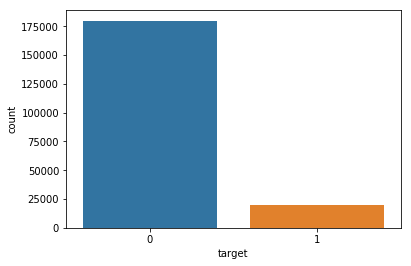

In [18]:
# data unbalanced
sns.countplot(train['target']);

In [19]:
zero_class = train[train['target']==0]
zero_class_count = zero_class.shape[0]
print("Negative samples (y=0): %d" % zero_class_count)

one_class = train[train['target']==1]
one_class_count = one_class.shape[0]
print("Positive samples (y=1): %d" % one_class_count)

zero_to_one_ratio = zero_class_count/one_class_count
print("Ratio: %.2f" % zero_to_one_ratio)

Negative samples (y=0): 179902
Positive samples (y=1): 20098
Ratio: 8.95


## DATA EXPLORATION: Feature-target dependence (visualization)

In [8]:
train2 = train.set_index(['ID_code'])
test2 = test.set_index(['ID_code'])

y_train = train2['target']
X_train = train2.drop(['target'], axis=1)

# X_test = test2.drop(['target'], axis=1)
X_test = test2

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]

Shape of X_train: (200000, 200)
Shape of X_test: (200000, 200)


In [14]:
# set plot options
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (7, 7)
title_config = {'fontsize': 20, 'y': 1.05}

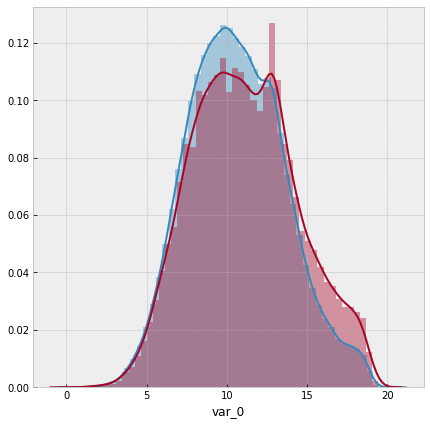

In [82]:
sns.distplot(X_train0['var_0'], kde=True, bins=50);
sns.distplot(X_train1['var_0'], kde=True, bins=50);

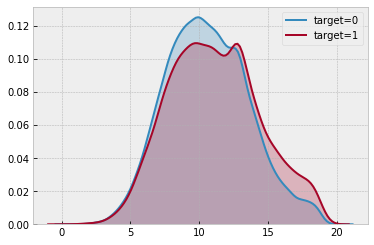

In [141]:
sns.kdeplot(X_train0['var_0'], label='target=0', shade=True);
sns.kdeplot(X_train1['var_0'], label='target=1', shade=True);

In [83]:
def plot_numerical_bylabel(data, col, size=[8, 4], bins=50):
    '''
    use this function to compare the distribution of numercial features
    '''
    plt.figure(figsize=[12, 6])
    l1 = data.loc[data.target==1, col]
    l0 = data.loc[data.target==0, col]
    
    plt.subplot(1,2,1)
    sns.distplot(l0.dropna(), kde=True,bins=bins)
    plt.title('Non-default (Y=0): Distribution of %s' % col)
    
    plt.subplot(1,2,2)
    sns.distplot(l1.dropna(), kde=True,bins=bins)
    plt.title('Default (Y=1): Distribution of %s' % col)
    
    plt.show()

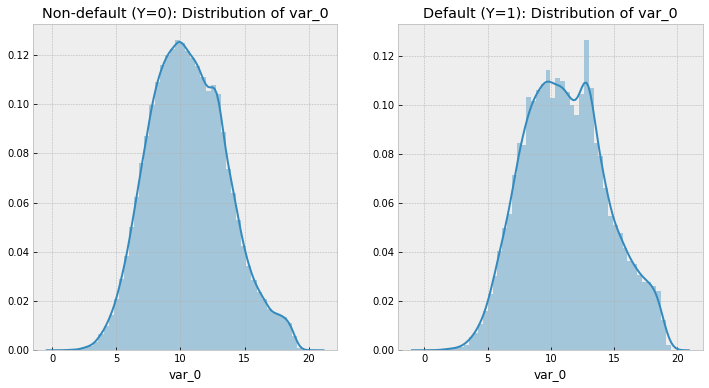

In [84]:
plot_numerical_bylabel(train, col='var_0')

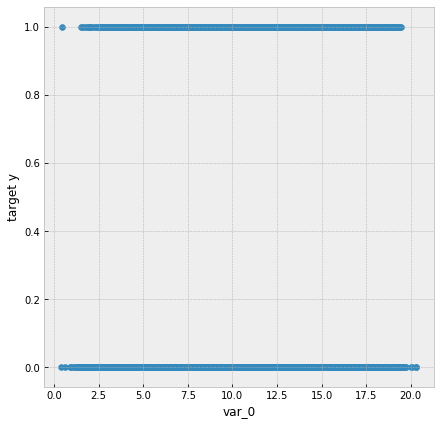

In [85]:
key = 'var_0'
plt.scatter(X_train[key], y_train)
plt.xlabel(key)
plt.ylabel('target y')
plt.show()

## DATA EXPLORATION: Density plots by label

In [15]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid');
    plt.figure();
    fig, ax = plt.subplots(10,10,figsize=(18,22));

    for feature in features:
        i += 1
        plt.subplot(10,10,i);
        sns.kdeplot(df1[feature], bw=0.5,label=label1);
        sns.kdeplot(df2[feature], bw=0.5,label=label2);
        plt.xlabel(feature, fontsize=9);
        locs, labels = plt.xticks();
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6);
        plt.tick_params(axis='y', which='major', labelsize=6);
    plt.show();

<Figure size 504x504 with 0 Axes>

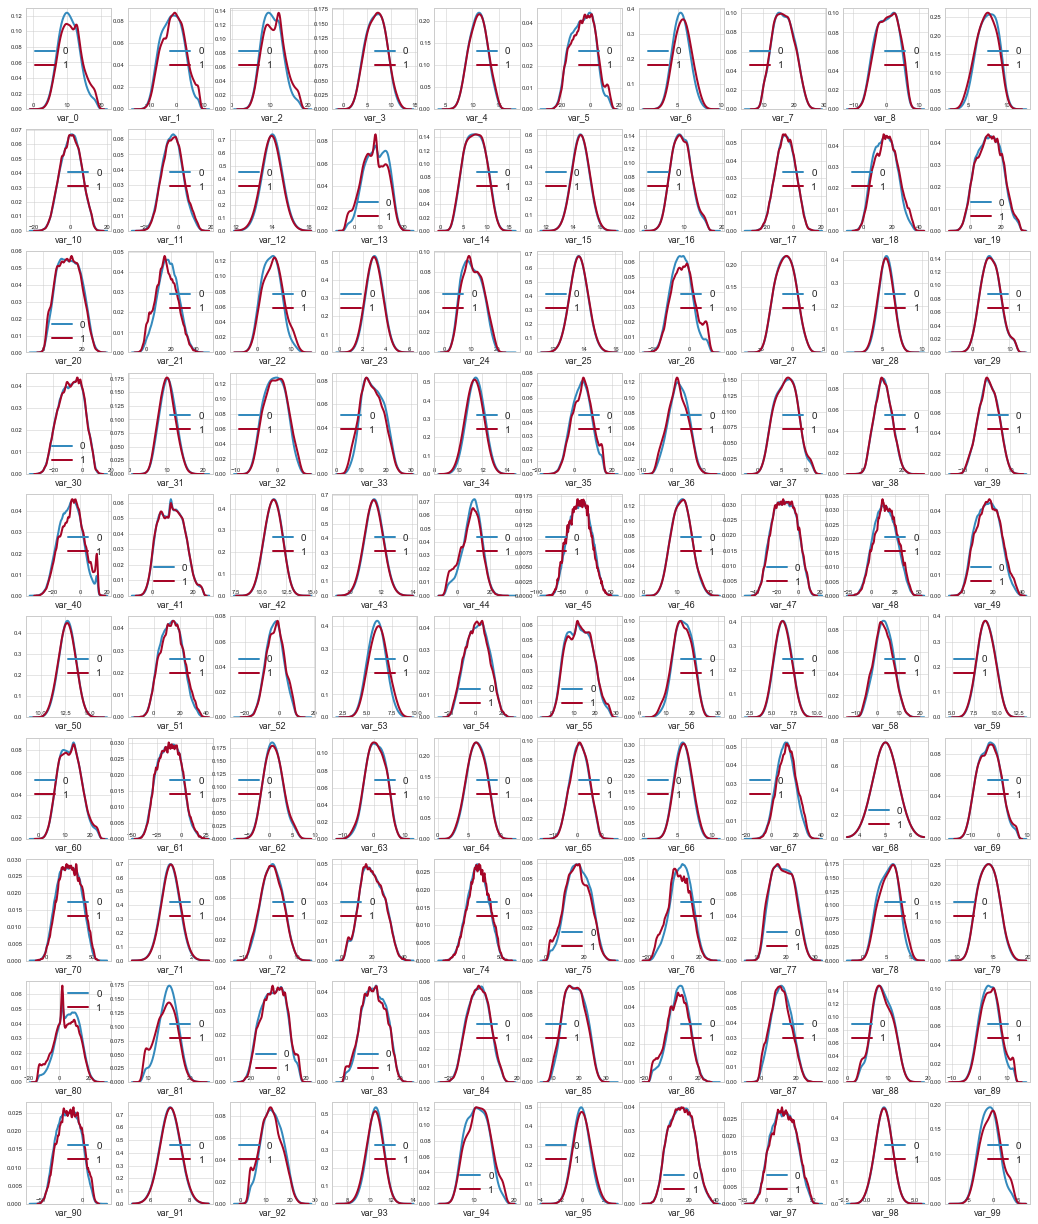

In [16]:
# check first 100 features
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]

features100 = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features100)

<Figure size 504x504 with 0 Axes>

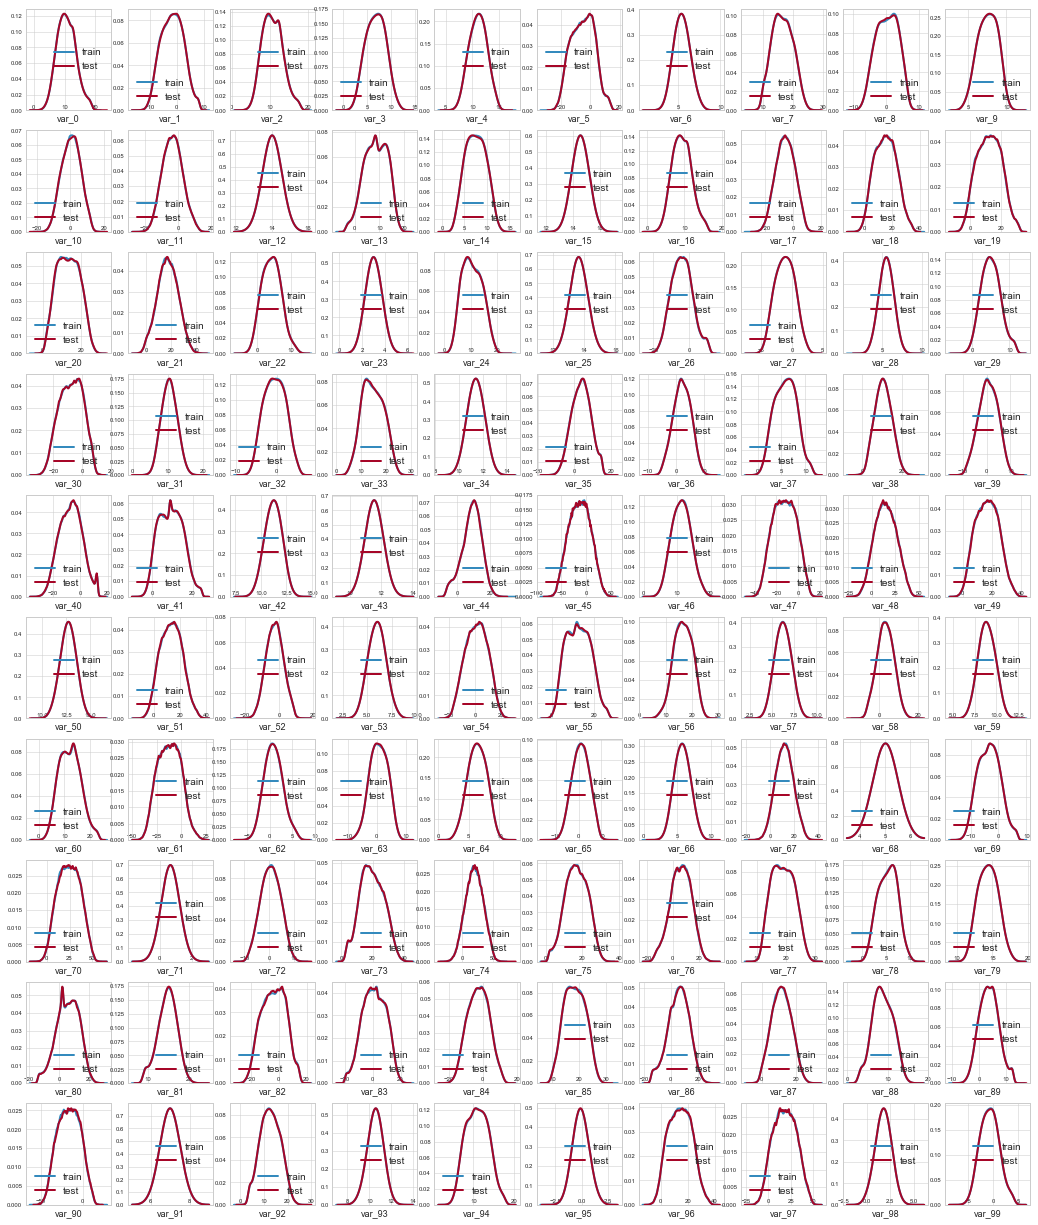

In [17]:
# compare train and test distributions
plot_feature_distribution(train, test, 'train', 'test', features100)

In [18]:
def plot_single_feat_by_label(data, feature):
    "plot single feature by target label"
    
    data0 = data.loc[data['target'] == 0]
    data1 = data.loc[data['target'] == 1]
    
    sns.kdeplot(data0[feature], bw=0.5, label='0');
    sns.kdeplot(data1[feature], bw=0.5, label='1');
    plt.show();

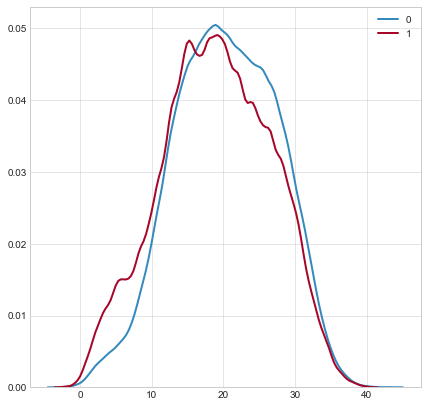

In [19]:
plot_single_feat_by_label(train, 'var_174')

# FEATURE NORMALIZATION

In [20]:
# CLEANING helper function
def get_normalized(data):
    """
    function to normalize attribute features
    """
    
    # normalization
    cols_normalize = data.columns.difference(['target','ID_code'])
    data[cols_normalize] = data[cols_normalize].astype('float64')

    scaler = StandardScaler()
    data_norm = pd.DataFrame(scaler.fit_transform(data[cols_normalize]), 
                             columns=cols_normalize, 
                             index=data.index)

    join_df = data[data.columns.difference(cols_normalize)].join(data_norm)
    data_norm = join_df.reindex(columns = data.columns)
    
    return data_norm, scaler

In [21]:
# normalize train data
train_norm, scaler =  get_normalized(train)
# transform test data with same scaler
test['target'] = np.nan
cols_normalize = test.columns.difference(['target','ID_code'])
test[cols_normalize] = test[cols_normalize].astype('float64')
test_norm = pd.DataFrame(scaler.transform(test[cols_normalize]), 
                         columns=cols_normalize, 
                         index=test.index)

join_df = test[test.columns.difference(cols_normalize)].join(test_norm)
test_norm = join_df.reindex(columns = test.columns)

In [22]:
train_norm.head()

ID_code  target     var_0     var_1     var_2     var_3     var_4  \
0  train_0       0 -0.577102 -1.273737  0.451707 -0.833709  0.235571   
1  train_1       0  0.269959 -0.622138  1.190360 -0.688846  0.790975   
2  train_2       0 -0.681113 -0.276066  0.516988  0.536516 -0.305477   
3  train_3       0  0.125158 -0.129426 -0.667575  0.195355  0.927992   
4  train_4       0 -0.277303  0.035610  0.817683 -0.077829  0.738607   

      var_5     var_6     var_7     var_8     var_9    var_10    var_11  \
0 -0.536430 -0.334926  0.608751 -1.561580 -1.473796  0.460091  1.076623   
1  1.539900  0.244461 -0.003525  0.858974  0.419300 -0.144987  1.893408   
2 -0.511033  1.769839 -0.564749 -1.561370 -1.307408 -0.130752 -1.343197   
3  0.410672  0.500633 -0.474201 -1.843910  0.548767  0.347543  1.014331   
4  0.955574  0.613372  0.791544  1.794753  0.090006 -1.788863 -1.490109   

     var_12    var_13    var_14    var_15    var_16    var_17    var_18  \
0 -0.054077 -1.714773  0.561098 -0.009778 -1.401636 -0.229802 -1.395940   
1 -0.000409 -0.025160 -0.935586 -2.120000  1.757336 -1.473077 -0.948119   
2  0.888789 -0.262491 -0.005875  0.179918 -0.647163  0.589523 -1.342815   
3 -0.934857  0.741492 -0.480762  0.641408  0.551235  0.784619  0.088977   
4 -0.925386 -0.138103  0.112013  1.171149 -0.330867  0.391612 -1.110346   

     var_19    var_20    var_21    var_22    var_23    var_24    var_25  \
0  2.285292 -0.468989 -0.126734 -0.606166 -1.039947  1.005683 -0.823003   
1  2.017368 -1.678317 -1.771135  1.491237  0.668183 -0.954799  0.782756   
2  1.005285  0.759841  0.107340 -1.085317  0.937877 -1.299019 -1.575276   
3  0.160959  1.192958 -0.573410  0.883010 -0.562999  0.410618  0.242366   
4 -0.140479  1.384169  0.207760  2.038227 -0.579511  0.959326 -0.434959   

     var_26    var_27    var_28    var_29    var_30    var_31    var_32  \
0 -0.184673  0.479492 -0.768964  0.360340  0.926437  1.162587 -1.299824   
1 -1.302434 -0.932390 -0.621140 -1.722433 -0.202250 -1.165592  0.695096   
2 -0.665103 -1.158352  0.399967  0.416687 -0.428711  0.968919 -0.685601   
3  0.822099  0.152265  0.477453 -0.846035 -0.948135  0.022063 -0.796119   
4  1.220617 -1.446727  0.470432  1.101452  0.568668 -0.428840  0.194985   

     var_33    var_34    var_35    var_36    var_37    var_38    var_39  \
0  0.489773 -0.447275  1.300500 -0.484245  0.897088 -1.396490  0.789254   
1  1.063517 -0.118257 -0.599010  0.196242 -0.011334  0.040634  0.741083   
2  0.987446 -0.718871  0.051395  0.804550  0.473703  0.058326  0.058332   
3 -1.988413 -1.523135 -1.884007  1.918310 -1.340964 -0.343157  0.000871   
4  1.052620  1.793625 -0.619668  0.193903 -0.022447  2.024278  0.192203   

     var_40    var_41    var_42    var_43    var_44    var_45    var_46  \
0  0.179582 -0.324223  0.509123  1.533101  0.456291  0.265485 -1.889139   
1 -0.530145 -1.250719 -1.932294  0.692012 -1.305067 -1.620194 -1.382515   
2 -0.820353 -1.188257  0.439581  1.520181 -0.821217  0.223868 -0.065019   
3  0.349803 -1.740777  0.796914 -0.925566 -0.152428 -0.559888  0.494288   
4  0.136390  0.803062  0.998211 -0.190097 -0.345514 -2.466105  0.887680   

     var_47    var_48    var_49    var_50    var_51    var_52    var_53  \
0 -0.164640  0.116264 -1.445719  0.257933  1.907481  0.368029 -1.091818   
1  1.197234  1.730162  1.148358 -1.310794 -0.024833 -0.316814  0.889088   
2  0.631894  0.530817 -1.246871  0.250560  0.751982  0.653014  0.519556   
3 -2.145039 -1.224793 -1.056386 -0.083541 -0.473736  0.866172 -1.045397   
4  1.183018 -1.303489 -0.287140  0.847633 -0.359486  0.219058 -0.330917   

     var_54    var_55    var_56    var_57    var_58    var_59    var_60  \
0 -0.223968  0.366666 -1.514722 -1.119228 -0.269821  1.386852  0.953771   
1 -1.097157  1.028750  0.760624  0.930521 -0.292466 -0.073613 -0.981607   
2  0.971603 -1.135534 -0.280203 -0.568553 -0.483544  0.297470  0.104368   
3  0.826480 -0.061274 -0.609962  0.393682  0.032296  0.623161  0.858848   
4 -1.150257  0.246456  0.100231 -0.114

In [23]:
test_norm.head()

ID_code     var_0     var_1     var_2     var_3     var_4     var_5  \
0  test_0  0.126869  2.322801  0.847597  1.288432  0.218321  0.341439   
1  test_1 -0.707067  0.711580  0.223223 -0.788293 -1.158820  0.133993   
2  test_2 -1.709586 -2.155656 -0.217537  0.123021 -0.502440  1.891142   
3  test_3 -0.704764  0.075412  0.494837 -0.108466 -1.375436  1.047877   
4  test_4  0.337458  0.369113  1.292864  0.466923 -1.216671 -0.447586   

      var_6     var_7     var_8     var_9    var_10    var_11    var_12  \
0  0.508134  0.503691  0.554979  1.006232 -0.439781 -0.185889 -0.286110   
1  0.704648  0.610213 -1.409478 -1.290081 -0.322725  0.488188  0.467867   
2 -0.593060  1.084780  0.371820  0.629086 -0.927149  0.034068 -1.835631   
3 -0.541479  1.176147  0.927599 -0.088608 -0.069961 -0.304896  0.150597   
4  1.673832 -1.738131  0.811624 -0.342926  0.855908 -0.006215  0.406833   

     var_13    var_14    var_15    var_16    var_17    var_18    var_19  \
0 -1.764067  0.001421 -0.177372 -0.637544 -1.995527  0.042870  0.467411   
1 -1.285376 -0.906982 -0.941987 -0.904689  1.542344  1.772547 -1.544088   
2 -1.015607  1.475106 -0.875678  0.215231  1.244054  0.760899  1.047652   
3  1.071396  0.546462  0.393661  0.275683 -1.438202 -1.670631  1.130612   
4  0.094184 -1.250057  0.019368  0.988591  1.317632  0.352626  0.170325   

     var_20    var_21    var_22    var_23    var_24    var_25    var_26  \
0 -1.630651  0.188923 -0.953503  0.087039 -1.094319  1.581958 -0.917745   
1 -0.194681 -1.722553  0.334405 -1.132565  1.488390 -0.578550 -0.199076   
2 -0.140276 -0.596383  0.155153 -0.428816 -1.420483 -0.351957 -1.919806   
3  0.212092 -0.574045 -0.468663  2.315958  0.845910  1.657606  0.854621   
4 -1.989077 -0.116144  0.874302  1.104515  0.813426  0.746683  2.140749   

     var_27    var_28    var_29    var_30    var_31    var_32    var_33  \
0 -0.691596  0.226868 -0.484520  0.739423 -0.522503  0.996430 -0.462448   
1 -1.658381  0.223421 -0.786477 -0.349554  0.509635 -0.175095  0.131956   
2  0.638184  2.208829 -0.620380 -0.183682 -0.306056  1.398506  1.742921   
3 -0.137817 -0.352300  0.587639  1.745578 -0.388468  1.111237 -1.055395   
4 -0.739965 -0.392511  0.750258 -1.005421  0.106883 -1.644052  0.640988   

     var_34    var_35    var_36    var_37    var_38    var_39    var_40  \
0 -0.186203  0.830903 -0.720593 -1.038260 -0.201391  1.990630 -1.075581   
1 -1.473654 -0.568756  1.460133 -1.567658  0.520151 -0.544764  2.023907   
2  0.969420  1.174427  0.603522 -0.389159 -0.601892  0.053441 -1.492721   
3 -1.162361 -1.235880  1.245131 -1.159075  1.383786  2.008104  0.228621   
4  0.798634 -0.159686  0.662625  0.396138 -1.093935 -0.072123 -0.931353   

     var_41    var_42    var_43    var_44    var_45    var_46    var_47  \
0  1.612769  0.092019  0.859972  0.748716 -0.901171  0.297539  2.007889   
1 -1.038411 -0.931273  0.634519 -1.146878 -1.331134  0.771092 -0.464248   
2 -0.685855 -2.334312  1.970765 -0.100251  1.299549 -0.431528 -0.791946   
3 -1.405247  1.656698 -0.471106 -0.382275 -0.012915  0.841744  1.652836   
4 -0.700675  0.590877  1.498217  1.697207  1.154601  1.707081  0.971200   

     var_48    var_49    var_50    var_51    var_52    var_53    var_54  \
0  0.219283  0.021424  0.451656  0.119452 -0.466087  1.716547 -0.197644   
1 -0.731192 -0.524915 -1.521288  1.461301  0.823669  1.097784  0.902958   
2 -0.529581 -1.088796 -1.225643 -0.334911  0.378178 -0.467562  0.978948   
3  1.465842 -1.378227 -0.191968 -1.466996 -0.318860  0.320406  0.034297   
4 -1.193513 -0.411075  0.074474 -1.105545  0.476282 -0.430426 -0.037569   

     var_55    var_56    var_57    var_58    var_59    var_60    var_61  \
0  0.683763  0.755455  0.177210 -1.995132  0.463006 -0.053102  0.720279   
1  0.646399  1.433954  0.833291 -0.351396  0.694640 -1.614568 -0.581743   
2  2.308807  0.915476 -0.991937 -1.677584 -0.485641 -0.752661  0.540729   
3  0.140025 -0.344663  0.759834 -0.332823  1.298761  0.741308  0.671857   
4  1.123002 -1.121491  0.210543

In [24]:
test_norm.describe()

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.006966       0.000834      -0.002931      -0.004069   
std         0.998905       0.997648       0.997350       1.004605   
min        -3.451008      -3.312510      -3.165599      -3.337191   
25%        -0.735825      -0.758636      -0.749593      -0.766416   
50%        -0.054642       0.009166      -0.058500       0.012637   
75%         0.677519       0.733579       0.673953       0.749308   
max         3.830039       2.719168       3.028871       3.105480   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.001192       0.001877       0.007172      -0.004888   
std         0.995879       1.000769       0.997786       1.001877   
min        -3.446354      -2.887062      -3.683972      -3.169086   
25%        -0.731455      -0.780350      -0.734301      -0.764160   
50%         0.013195       0.029405      -0.020019      -0.036029   
75%         0.723944       0.764047       0.688724       0.745655   
max         3.055035       2.838397       3.338950       3.436723   

               var_8          var_9         var_10         var_11  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.002109       0.001758      -0.004182      -0.003845   
std         1.000225       0.997408       1.001433       0.998527   
min        -3.072701      -2.691301      -4.193359      -3.779783   
25%        -0.776584      -0.763875      -0.730867      -0.716287   
50%         0.026357       0.052437       0.017726      -0.011617   
75%         0.793928       0.823914       0.721363       0.683075   
max         2.814999       2.782330       3.603155       3.352780   

              var_12         var_13         var_14         var_15  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.006926       0.002293      -0.002181       0.001404   
std         1.000062       0.997670       1.003272       0.999712   
min        -3.154171      -2.860538      -3.054984      -3.326916   
25%        -0.699667      -0.745089      -0.786558      -0.754719   
50%         0.003274       0.018788      -0.018086      -0.001034   
75%         0.730943       0.806261       0.771172       0.734677   
max         3.462204       2.818149       3.196533       2.975087   

              var_16         var_17         var_18         var_19  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.004534      -0.001150       0.002772       0.002264   
std         0.995091       1.005045       0.999444       0.999142   
min        -3.526594      -3.457704      -3.383904      -3.143553   
25%        -0.734673      -0.715248      -0.765004      -0.764851   
50%        -0.040808      -0.000219      -0.005198       0.005713   
75%         0.665608       0.727756       0.734967       0.750735   
max         3.142015       3.701643       3.016677       2.875412   

              var_20         var_21         var_22         var_23  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.001282      -0.003329      -0.002254       0.000317   
std         1.001362       1.000407       0.998621       1.002010   
min        -2.710151      -3.318287      -3.324998      -3.091600   
25%        -0.800052      -0.701074      -0.746899      -0.733053   
50%        -0.012294      -0.005683      -0.012792      -0.021902   
75%         0.786780       0.704409       0.692698       0.732902   
max         3.196756       3.679602       3.419009       3.805447   

              var_24         var_25         var_26         var_27  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.004480      -0.001842       0.012058       0.005494   
std         0.998362       0.999717       1.003995       1.000692   
min    

In [25]:
test_norm_stat = test_norm.describe()

In [26]:
# check if statistics of test set comparable to train set
print('Max mean of all features in normalized test set:', test_norm_stat.loc['mean'].max())
print('Min mean of all features in normalized test set:', test_norm_stat.loc['mean'].min())
print('Max std of all features in normalized test set:', test_norm_stat.loc['std'].max())
print('Min std of all features in normalized test set:', test_norm_stat.loc['std'].min())

Max mean of all features in normalized test set: 0.016207308553122166
Min mean of all features in normalized test set: -0.010396715032110523
Max std of all features in normalized test set: 1.0057334474079935
Min std of all features in normalized test set: 0.9900220873018967


# OUTLIER DETECTION

https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/random_cut_forest

This is __work in progress__. 

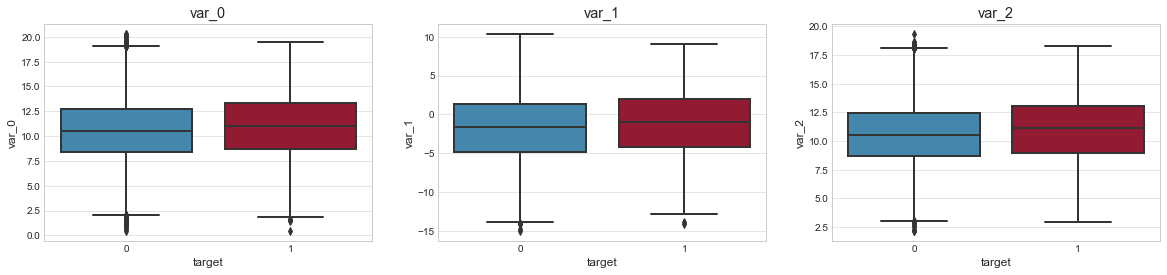

In [23]:
# Box plots 
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="target", y="var_0", data=train, ax=axes[0])
axes[0].set_title('var_0')

sns.boxplot(x="target", y="var_1", data=train, ax=axes[1])
axes[1].set_title('var_1')

sns.boxplot(x="target", y="var_2", data=train, ax=axes[2])
axes[2].set_title('var_2')

plt.show()

In [45]:
def plot_boxplot_distribution(df, features):
    i = 0
    sns.set_style('whitegrid');
    plt.figure();
    fig, axes = plt.subplots(10,10, figsize=(18,22));

    for feature in features:
        i += 1
        plt.subplot(10,10,i);
        sns.boxplot(x="target", y=feature, data=df)
        #axes[i].set_title(feature)
        
        #sns.boxplot(x="target", y="var_0", data=train, ax=axes[0])
        #axes[0].set_title('var_0')
        
        plt.xlabel(feature, fontsize=9);
        locs, labels = plt.xticks();
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6);
        plt.tick_params(axis='y', which='major', labelsize=6);
    plt.show();

<Figure size 504x504 with 0 Axes>

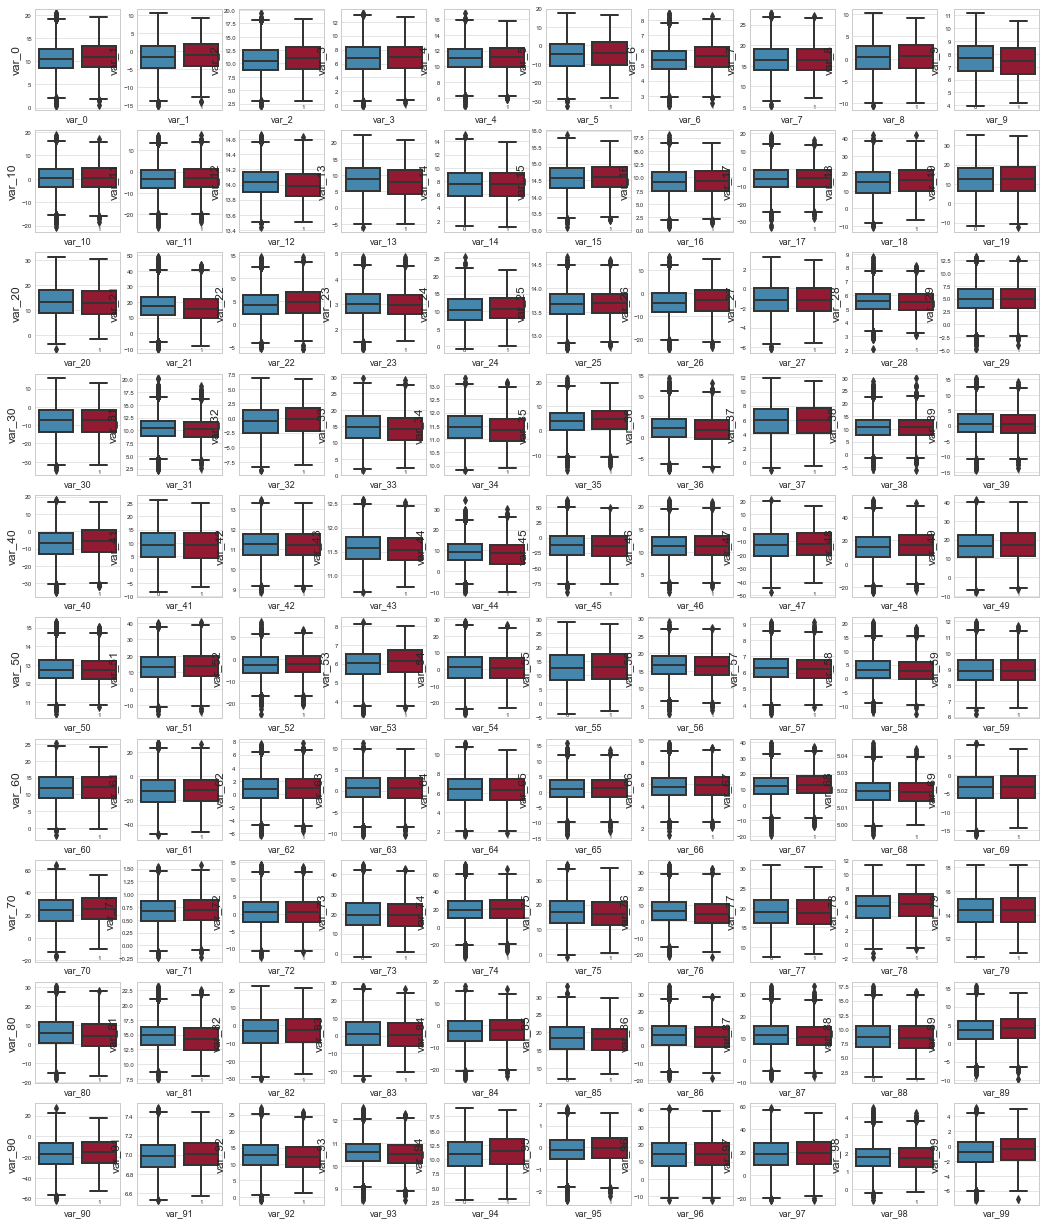

In [46]:
plot_boxplot_distribution(train, features100)

In [ ]:
# OUTLIER REMOVAL: WORK-in-PROGRESS
V17_non_fraud = normalized_df.query('V17 > -7 & Class == 0')
V17_fraud = normalized_df.query('Class == 1')
normalized_df_no_outlier = pd.concat([V17_non_fraud,V17_fraud])
# re-shuffle
normalized_df_no_outlier = normalized_df_no_outlier.sample(frac=1)

## Outlier Detection: Method 1 — Standard Deviation

In [20]:
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data):
    
    anomalies = []

    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    print('Lower limit (3 std):', lower_limit)
    print('Upper limit (3 std):', upper_limit)
    
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

In [21]:
find_anomalies(train['var_0'])

Lower limit (3 std): 1.559784440403778
Upper limit (3 std): 19.800044063596523


[1.335,
 0.5979,
 1.4449,
 1.3215,
 1.1563,
 1.492,
 0.8935,
 1.335,
 0.9302,
 1.0147,
 20.315,
 20.315,
 1.2832,
 1.1862,
 0.4528,
 1.2968,
 20.074,
 1.2944,
 1.4059,
 0.4084,
 1.4566,
 1.5307,
 19.9984]

## Outlier Detection: Method 2 — Boxplots

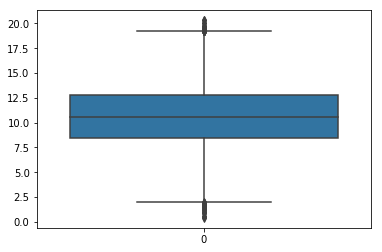

In [23]:
sns.boxplot(data=train['var_0']);

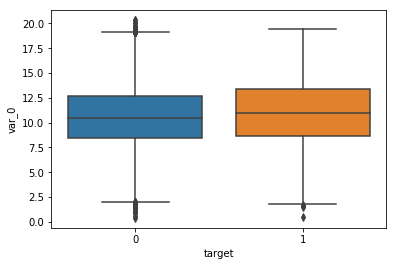

In [25]:
sns.boxplot(x="target", y='var_0', data=train);

## Outlier Detection: Method 3— DBScan Clustering

In [26]:
from sklearn.cluster import DBSCAN

In [36]:
features_train = train.drop(['ID_code', 'target'], axis=1)
print(features_train.shape)

(200000, 200)


In [37]:
outlier_detection = DBSCAN(min_samples = 2, eps = 3)
clusters = outlier_detection.fit_predict(features_train)
list(clusters).count(-1)

200000

- The output of the above code is the total number of noisy points. SKLearn labels the noisy points as (-1). 
- The downside with this method is that the higher the dimension, the less accurate it becomes. 
- You also need to make a few assumptions like estimating the right value for eps which can be challenging.

## Outlier Detection: Method 4 — Isolation Forest

In [35]:
from sklearn.ensemble import IsolationForest

- This code will output the predictions for each data point in an array. 
- If the result is -1, it means that this specific data point is an outlier. 
- If the result is 1, then it means that the data point is not an outlier

In [38]:
clf = IsolationForest(behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(features_train)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [41]:
number_outliers_isolation_forest = list(preds).count(-1)
print('Number of outliers accoridng to Isolation Forest:', number_outliers_isolation_forest)

Number of outliers accoridng to Isolation Forest: 57


## Outlier Detection: Method 5 — Robust Random Cut Forest

- Random Cut Forest (RCF) algorithm is __Amazon’s__ unsupervised algorithm for detecting anomalies. 
- It works by associating an anomaly score as well. Low score values indicate that the data point is considered “normal.” High values indicate the presence of an anomaly in the data. The definitions of “low” and “high” depend on the application but common practice suggests that scores beyond three standard deviations from the mean score are considered anomalous.
- The great thing about this algorithm is that it works with very high dimensional data. It can also work on real-time streaming data (built in AWS Kinesis Analytics) as well as offline data.

https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/random_cut_forest

# RESAMPLING: UNDERSAMPLING and OVERSAMPLING

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

https://github.com/wmlba/innovate2019/blob/master/Credit_Card_Fraud_Detection.ipynb

__NOTE__: Resample only ___training___ data and ckeck performance of classifier on dev set with real (unbalanced) distribution.

## Undersampling

In [47]:
# Shuffle the Dataset.
shuffled_df = train.sample(frac=1, random_state=42)

# minority classes
minority_df = shuffled_df.loc[shuffled_df['target'] == 1]
number_min = len(minority_df)

#Randomly select majority observations and combine.
majority_df = shuffled_df.loc[shuffled_df['target'] == 0].sample(n=number_min, random_state=42)
undersample_df = pd.concat([majority_df, minority_df])
undersample_df = undersample_df.sample(frac=1, random_state=42)

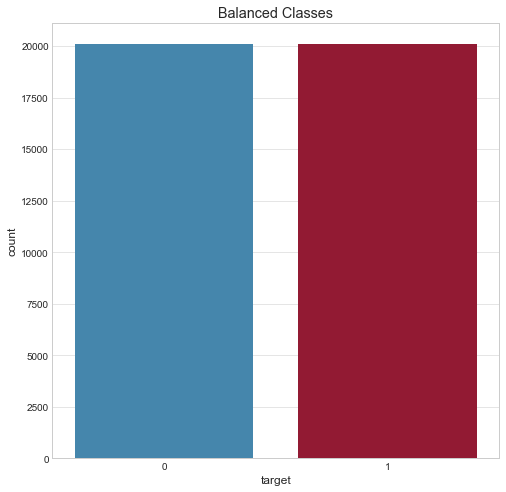

In [48]:
# PLOT distribution of target after down-sampling
plt.figure(figsize=(8, 8))
sns.countplot('target', data=undersample_df)
plt.title('Balanced Classes')
plt.show()

In [52]:
print('Shape of undersampled data:', undersample_df.shape)

Shape of undersampled data: (40196, 202)


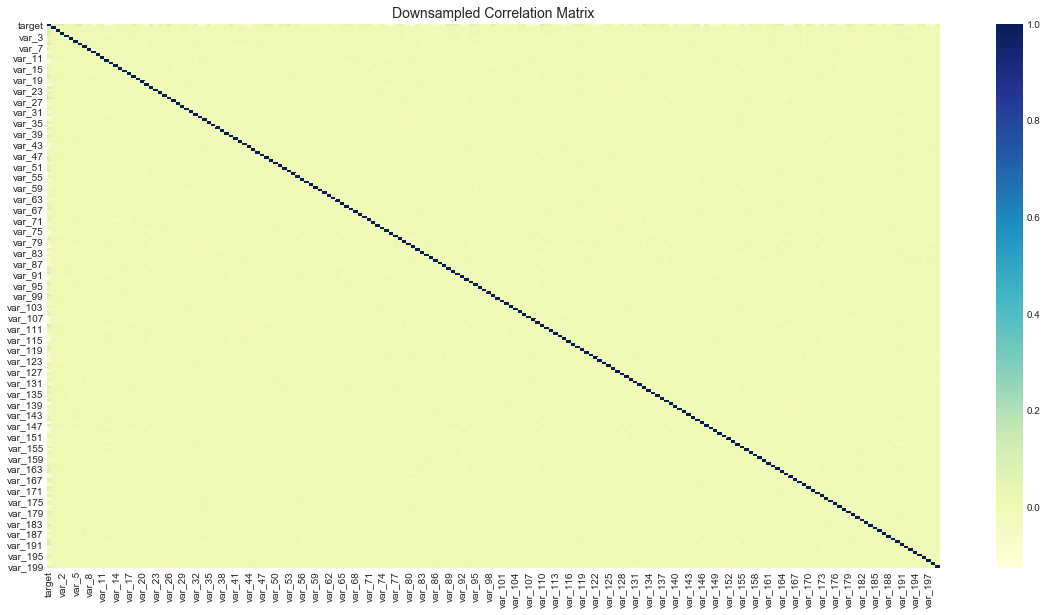

In [51]:
# PLOT DataFrame Correlation
fig, ax = plt.subplots(figsize=(20,10))         
corr = undersample_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Downsampled Correlation Matrix", fontsize=14)
plt.show()

## Oversampling

In [55]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_sample(train2.drop('target', axis=1), train2['target'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = train2.columns

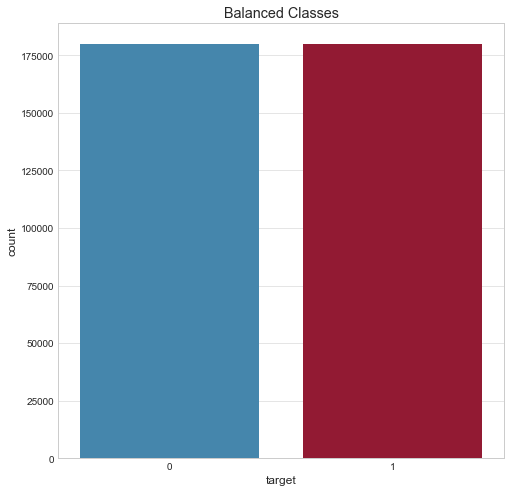

In [56]:
# PLOT distribution of target after up-sampling with SMOTE
plt.figure(figsize=(8, 8))
sns.countplot('target', data=oversampled_train)
plt.title('Balanced Classes')
plt.show()

In [57]:
print('Shape of oversampled data:', oversampled_train.shape)

Shape of oversampled data: (359804, 201)


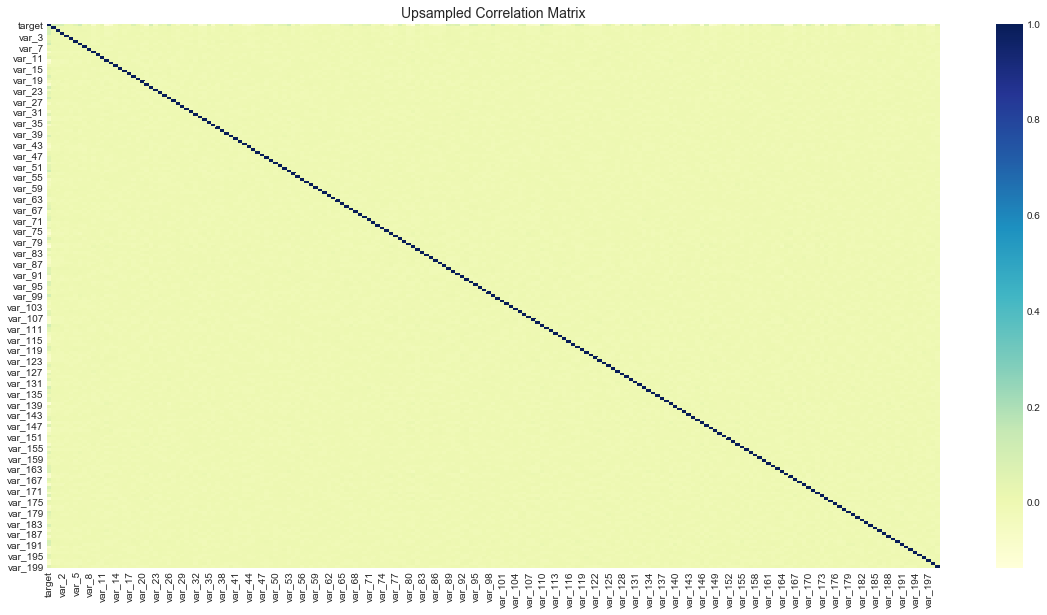

In [58]:
# PLOT DataFrame Correlation
fig, ax = plt.subplots(figsize=(20,10))         
corr = oversampled_train.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Upsampled Correlation Matrix", fontsize=14)
plt.show()

In [59]:
oversampled_train.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8   var_9  var_10   var_11   var_12   var_13  var_14   var_15  \
0 -4.9200  5.7470  2.9252   3.1821  14.0137   0.5745  8.7989  14.5691   
1  3.1468  8.0851 -0.4032   8.0585  14.0239   8.4135  5.4345  13.7003   
2 -4.9193  5.9525 -0.3249 -11.2648  14.1929   7.3124  7.5244  14.6472   
3 -5.8609  8.2450  2.3061   2.8102  13.8463  11.9704  6.4569  14.8372   
4  6.2654  7.6784 -9.4458 -12.1419  13.8481   7.8895  7.7894  15.0553   

    var_16   var_17   var_18   var_19   var_20   var_21   var_22  var_23  \
0   5.7487  -7.2393   4.2840  30.7133  10.5350  16.2191   2.5791  2.4716   
1  13.8275 -15.5849   7.8000  28.5708   3.4287   2.7407   8.5524  3.3716   
2   7.6782  -1.7395   4.7011  20.4775  17.7559  18.1377   1.2145  3.5137   
3  10.7430  -0.4299  15.9426  13.7257  20.3010  12.5579   6.8202  2.7229   
4   8.4871  -3.0680   6.5263  11.3152  21.4246  18.9608  10.1102  2.7142   

    var_24   var_25   var_26  var_27  var_28  var_29   var_30   var_31  \
0  14.3831  13.4325  -5.1488 -0.4073  4.9306  5.9965  -0.3085  12.9041   
1   6.9779  13.8910 -11.7684 -2.5586  5.0464  0.5481  -9.2987   7.8755   
2   5.6777  13.2177  -7.9940 -2.9029  5.8463  6.1439 -11.1025  12.4858   
3  12.1354  13.7367   0.8135 -0.9059  5.9070  2.8407 -15.2398  10.4407   
4  14.2080  13.5433   3.1736 -3.3423  5.9015  7.9352  -3.1582   9.4668   

   var_32   var_33   var_34   var_35  var_36  var_37   var_38  var_39  \
0 -3.8766  16.8911  11.1920  10.5785  0.6764  7.8871   4.6667  3.8743   
1  1.2859  19.3710  11.3702   0.7399  2.7995  5.8434  10.8160  3.6783   
2 -2.2871  19.0422  11.0449   4.1087  4.6974  6.9346  10.8917  0.9003   
3 -2.5731   6.1796  10.6093  -5.9158  8.1723  2.8521   9.1738  0.6665   
4 -0.0083  19.3239  12.4057   0.6329  2.7922  5.8184  19.3038  1.4450   

    var_40   var_41   var_42   var_43   var_44   var_45   var_46   var_47  \
0  -5.2387   7.3746  11.5767  12.0446  11.6418  -7.0170   5.9226 -14.2136   
1 -11.1147   1.8730   9.8775  11.7842   1.2444 -47.3797   7.3718   0.1948   
2 -13.5174   2.2439  11.5283  12.0406   4.1006  -7.9078  11.1405  -5.7864   
3  -3.8294  -1.0370  11.7770  11.2834   8.0485 -24.6840  12.7404 -35.1659   
4  -5.5963  14.0685  11.9171  11.5111   6.9087 -65.4863  13.8657   0.0444   

    var_48   var_49   var_50   var_51  var_52  var_53  var_54   var_55  \
0  16.0283   5.3253  12.9194  29.0460 -0.6940  5.1736 -0.7474  14.8322   
1  34.4014  25.7037  11.8343  13.2256 -4.1083  6.6885 -8.0946  18.5995   
2  20.7477   6.8874  12.9143  19.5856  0.7268  6.4059  9.3124   6.2846   
3   0.7613   8.3838  12.6832   9.5503  1.7895  5.2091  8.0913  12.3972   
4  -0.1346  14.4268  13.3273  10.4857 -1.4367  5.7555 -8.5414  14.1482   

    var_56  var_57  var_58   var_59   var_60   var_61  var_62  var_63  var_64  \
0  11.2668  5.3822  2.0183  10.1166  16.1828   4.9590  2.0771 -0.2154  8.6748   
1  19.3219  7.0118  1.9210   8.8682   8.0109  -7.2417  1.7944 -1.3147  8.1042   
2  15.6372  5.8200  1.1000   9.1854  12.5963 -10.3734  0.8748  5.8042  3.7163   
3  14.4698  6.5850  3.3164   9.4638  15.7820 -25.0222  3.4418 -4.3923  8.6464   
4  16.9840  6.1812  1.9548   9.2048   8.6591 -27.7439 -0.4952 -1.7839  5.2670   

   var_65  var_66   var_67  var_68  var_69   var_70  var_71  var_72   var_73  \
0  9.5319  5.8056  22.4321  5.0109 -4.7010  21.6374  0.5663  5.1999   8.8600   
1  1.5365  5.4007   7.9344  5.0220  2.2302  40.5632  0.5134  3.1701  20.1068   
2 -1.1016  7.3667   9.8565  5.0228 -5.7828   2.3612  0.8520  6.3577  12.1719   
3  6.3072  5.6221  23

-----
# ENSEMBLE SAMPLER: Balanced Bagging Classifier

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html#imblearn.ensemble.BalancedBaggingClassifier

- When using ensemble classifiers, bagging methods work by building multiple estimators on a different randomly selected subset of data. In scikit-learn, the classifier is named ```BaggingClassifier```. However, this classifier does not allow to balance each subset of data. Therefore, when training on imbalanced data set, this classifier tends to favour the majority classes and create a biased model.
- In order to fix this, we can use ```BalancedBaggingClassifier``` from ```imblearn``` library. It allows the resampling of each subset of the dataset before training each estimator of the ensemble. Therefore, ```BalancedBaggingClassifier``` takes the same parameters as the scikit-learn ```BaggingClassifier``` in addition to two other parameters, ```sampling_strategy``` and replacement which control the behaviour of the random sampler. 
- That way, you can train a classifier that will handle the imbalance without having to undersample or oversample manually before training.

In [81]:
from imblearn.ensemble import BalancedBaggingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [70]:
# choose full BARE data set for cross validation
X = train.set_index(['ID_code'])
Y = X['target']
X = X.drop(['target'], axis=1)

In [83]:
# BASELINE: Create an object of the classifier (no HPO yet)
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(n_estimators = 500,
                                max_features = 20),
                                n_estimators = 500,
                                max_features = 20,
                                # ratio=0.5,
                                # sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

# Train the classifier.
# bbc.fit(X_train, y_train)
# preds = bbc.predict(X_train)

In [ ]:
# train model 
# compute results for different folds: check how general the model is
kfold = StratifiedKFold(n_splits=5, random_state=0)
scores = cross_val_score(bbc, X, Y, cv=kfold, scoring='roc_auc', verbose=0)
mean_score = scores.mean()

# print model
print(bbc)
print('---------------------------------------------------------------')

# print results
print('CV RESULTS:')
print('Average cross-validation AUC score: {:.3f}'.format(mean_score))
print('Std of cross-validation AUC score: {:.3f}'.format(scores.std()))

-----
# NAIVE BAYES MODEL


https://www.kaggle.com/blackblitz/gaussian-naive-bayes

In [33]:
train2 = train.set_index(['ID_code'])
test2 = test.set_index(['ID_code'])

y_train = train2['target']
X_train = train2.drop(['target'], axis=1)

X_test = test2.drop(['target'], axis=1)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (200000, 200)
Shape of X_test: (200000, 200)


In [35]:
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]

## NAIVE BAYES: Check Assumptions

Check if assumptions of NB are satisfied, i.e., the likelihood distributions are normal and independent.

In [34]:
# set plot options
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10, 10)
title_config = {'fontsize': 20, 'y': 1.05}

- We look at the likelihood distributions by plotting the KDE (Kernel Density Estimates) using the `pandas.DataFrame.plot.kde`. 
- Note that KDE is a similarity-based method so it gets slower with more data. 
- We can speed up by reducing the number of evaluation points (`ind` parameter), but this also decreases the resolution of the plot.

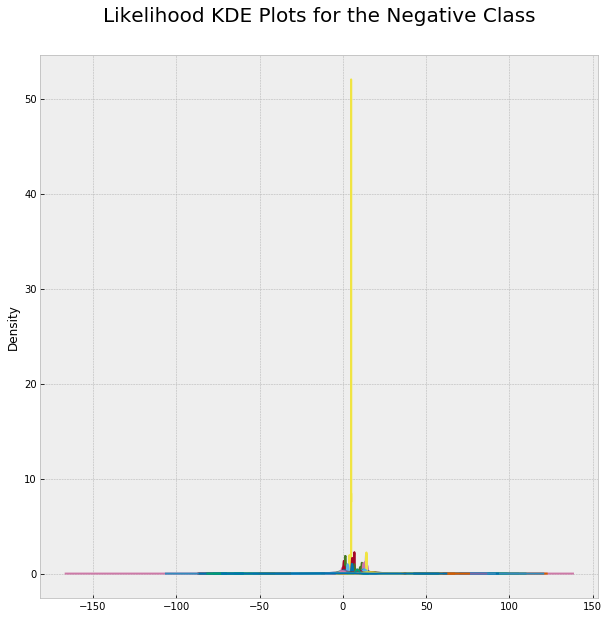

In [37]:
pd.DataFrame(X_train0).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class', **title_config);

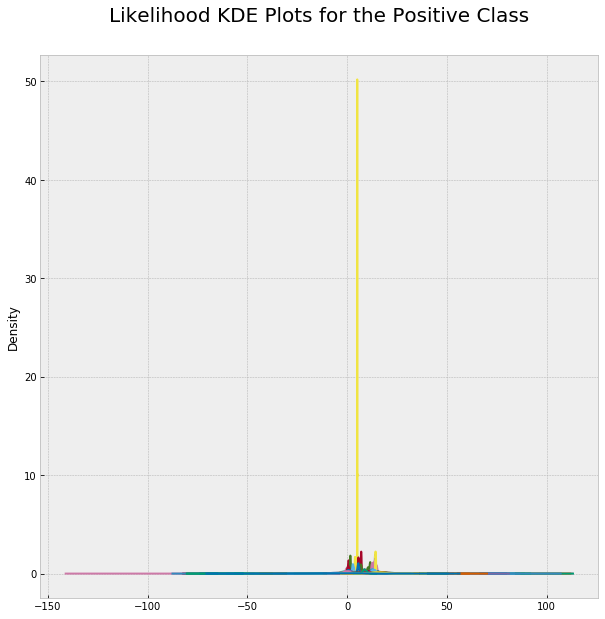

In [38]:
pd.DataFrame(X_train1).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class', **title_config);

- The KDE plots above show that the likelihood distributions have different centers and spread. 
- We will standardize them (subtract mean and divide by standard deviation) so that they have zero mean and unit variance. 
- We can use `sklearn.preprocessing.StandardScaler` for standardization.

In [40]:
scaler = StandardScaler()
scaled = pd.DataFrame(data=scaler.fit_transform(X_train), 
                      columns=X_train.columns, 
                      index=X_train.index)

scaled0 = scaled[y_train==0]
scaled1 = scaled[y_train==1]

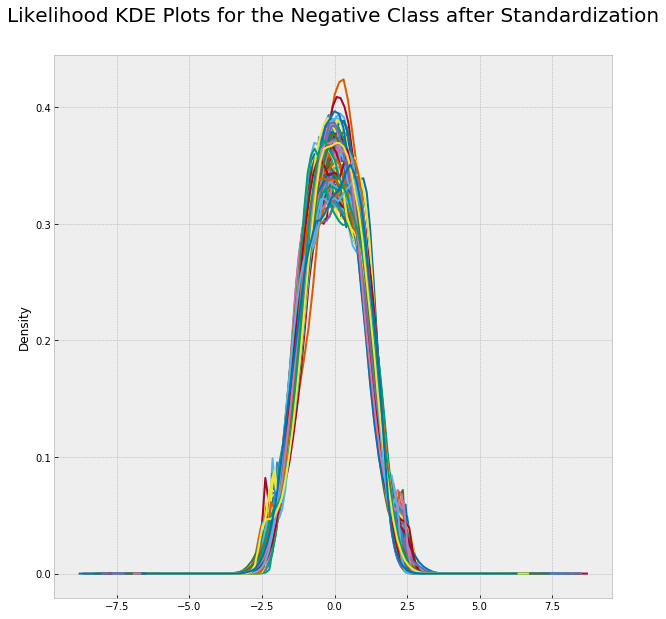

In [41]:
scaled0.plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Standardization', **title_config);

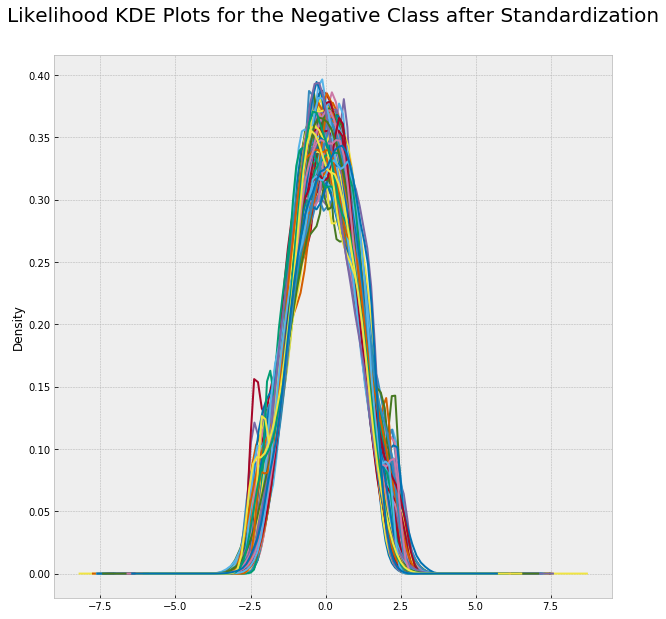

In [42]:
scaled1.plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Standardization', **title_config);

- Now the KDE plots above look approximately normal, but some have small bumps on the left or right. 
- We can proceed without doing anything, or we can use quantile transformation to remove the small bumps. 
- It turns out that the transformation provides only marginal improvement in performance (0.001 in cross-validation AUC) despite requiring significantly more computation. In practice, we might choose to skip the transformation. In this competition, however, we will do the transformation for that tiny improvement.

- Ideally, we need to apply the transformation to the features separately for the positive and negative classes. However, this does not translate to the test data (we do not know the target value). We will instead apply it to the features data so what we really get are normal unconditional distributions instead of normal conditional distributions. Still, we hope that the conditional distributions will become more normal as well. We can use `sklearn.preprocessing.QuantileTransformer` for quantile transformation.

In [43]:
trafo = QuantileTransformer(output_distribution='normal')
transformed = pd.DataFrame(data=trafo.fit_transform(X_train), 
                           columns=X_train.columns, 
                           index=X_train.index)

In [44]:
transformed0 = transformed[y_train==0]
transformed1 = transformed[y_train==1]

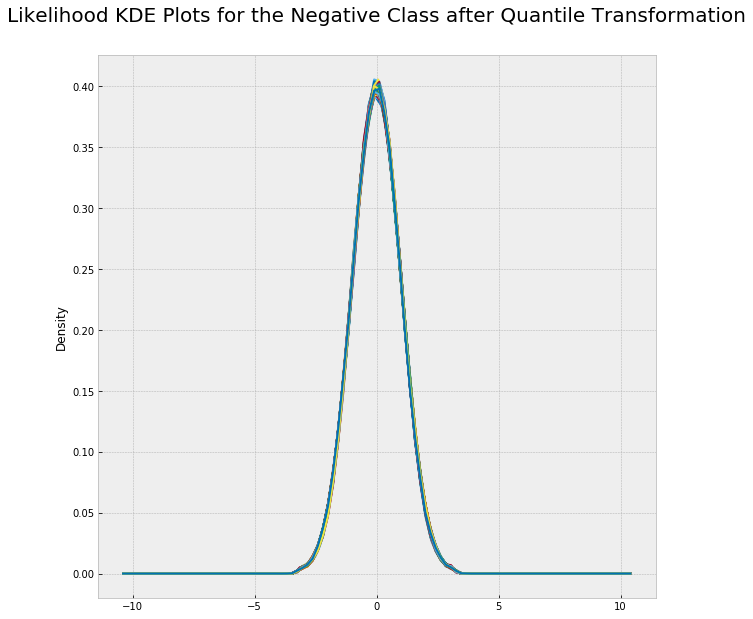

In [45]:
transformed0.plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Quantile Transformation', **title_config);

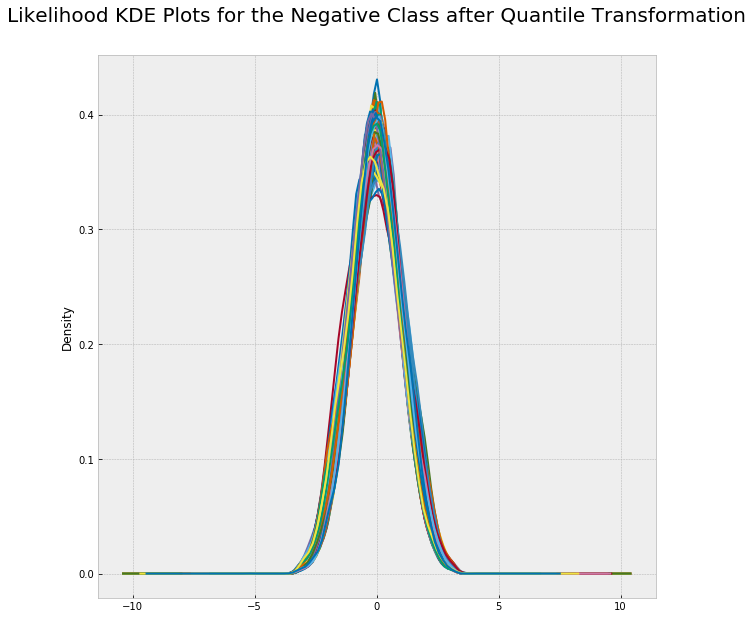

In [46]:
transformed1.plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Quantile Transformation', **title_config);

- In the KDE plots above, the likelihood distributions have become normal as we desire.

- Independence is difficult to check, but we can check the sample correlation coefficients. Small correlation coefficients mean that there is a weak linear pattern. We visualize the correlation matrix by using `matplotlib.pyplot.imshow`.

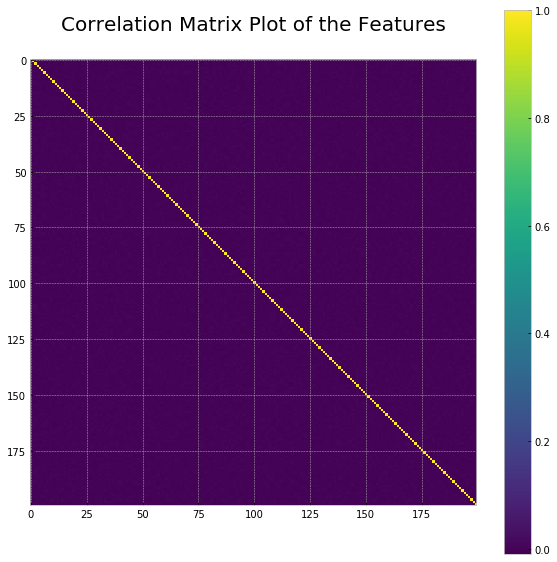

In [47]:
plt.imshow(transformed.corr())
plt.colorbar()
plt.title('Correlation Matrix Plot of the Features', **title_config);

- The correlation matrix plot above shows very small correlation coefficients between the features.

- Finally, it is important that  Y is dependent on  X. Otherwise, the posterior would be equal to the prior, and we would not need to do any calculation. We have already seen above that the positive and negative likelihood distributions are slightly different. Let us look at how the sample means and sample variances differ.

In [50]:
transformed0.mean().head()

var_0   -0.015666
var_1   -0.015240
var_2   -0.017040
var_3   -0.002370
var_4   -0.007255
dtype: float64

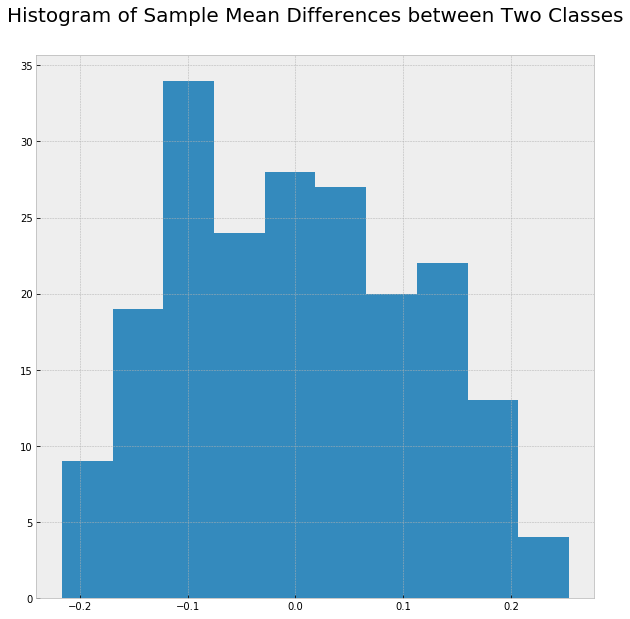

In [48]:
plt.hist(transformed0.mean() - transformed1.mean())
plt.title('Histogram of Sample Mean Differences between Two Classes', **title_config);

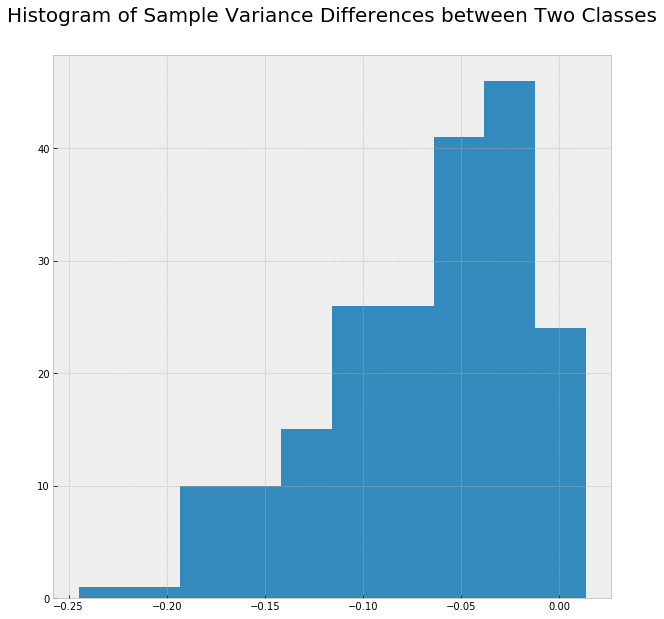

In [51]:
plt.hist(transformed0.var() - transformed1.var())
plt.title('Histogram of Sample Variance Differences between Two Classes', **title_config);

While the sample mean differences are more or less balanced around zero, the sample variance differences are almost entirely on the negative side. This means that the negative likelihood distributions are more concentrated around their means than the positive ones. These differences add to the discriminative power of the model. The further away the centers of the distributions or the greater the difference in the spread of the distributions, the more it can tell about which class the point is coming from.

## NAIVE BAYES: Training and Evaluation

In [52]:
# training with pipeline
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('quantiletransformer', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='normal', random_state=None,
          subsample=100000)), ('gaussiannb', GaussianNB(priors=None, var_smoothing=1e-09))])

In [54]:
# predictins train set
Y_prob_train = pipeline.predict_proba(X_train)[:,1]

0.8910597778946441

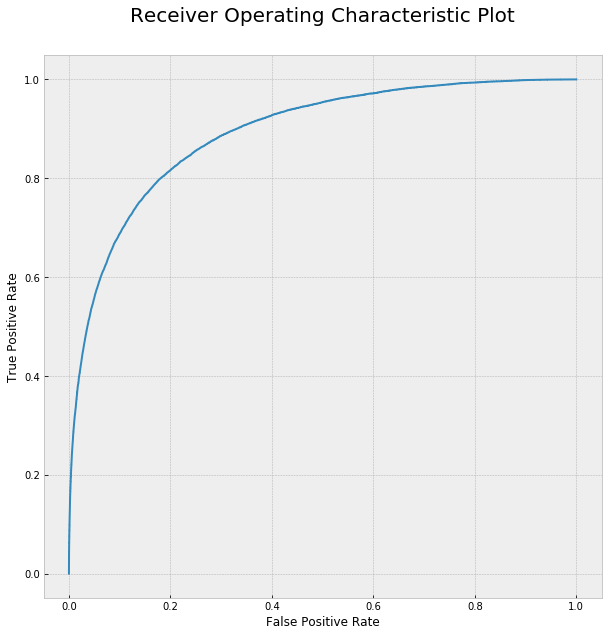

In [55]:
# ROC curve training set
fpr, tpr, thr = roc_curve(y_train, Y_prob_train)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

In [57]:
# 10-fold cross-validation
cv_nb = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10)
cv_nb_mean = cv_nb.mean()
cv_nb_std = cv_nb.std()
print('Average AUC of Naive Bayes model in 10-fold CV: {:.4f}'.format(cv_nb_mean))
print('Std AUC of Naive Bayes model in 10-fold CV: {:.4f}'.format(cv_nb_std))

Average AUC of Naive Bayes model in 10-fold CV: 0.8894
Std AUC of Naive Bayes model in 10-fold CV: 0.0027


## NAIVE BAYES: Test inference and submission

In [87]:
X_test.head()

var_0    var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
ID_code                                                                        
test_0   11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  18.2675   
test_1    8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196  18.6316   
test_2    5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950  20.2537   
test_3    8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397  20.5660   
test_4   11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595  10.6048   

          var_8   var_9  var_10  var_11   var_12   var_13   var_14   var_15  \
ID_code                                                                       
test_0   2.1337  8.8100 -2.0248 -4.3554  13.9696   0.3458   7.5408  14.5001   
test_1  -4.4131  5.9739 -1.3809 -0.3310  14.1129   2.5667   5.4988  14.1853   
test_2   1.5233  8.3442 -4.7057 -3.0422  13.6751   3.8183  10.8535  14.2126   
test_3   3.3755  7.4578  0.0095 -5.0659  14.0526  13.5010   8.7660  14.7352   
test_4   2.9890  7.1437  5.1025 -3.2827  14.1013   8.9672   4.7276  14.5811   

          var_16   var_17   var_18   var_19   var_20   var_21  var_22  var_23  \
ID_code                                                                         
test_0    7.7028 -19.0919  15.5806  16.1763   3.7088  18.8064  1.5899  3.0654   
test_1    7.0196   4.6564  29.1609   0.0910  12.1469   3.1389  5.2578  2.4228   
test_2    9.8837   2.6541  21.2181  20.8163  12.4666  12.3696  4.7473  2.7936   
test_3   10.0383 -15.3508   2.1273  21.4797  14.5372  12.5527  2.9707  4.2398   
test_4   11.8615   3.1480  18.0126  13.8006   1.6026  16.3059  6.7954  3.6015   

          var_24   var_25   var_26  var_27  var_28  var_29   var_30   var_31  \
ID_code                                                                        
test_0    6.4509  14.1192  -9.4902 -2.1917  5.7107  3.7864  -1.7981   9.2645   
test_1   16.2064  13.5023  -5.2341 -3.6648  5.7080  2.9965 -10.4720  11.4938   
test_2    5.2189  13.5670 -15.4246 -0.1655  7.2633  3.4310  -9.1508   9.7320   
test_3   13.7796  14.1408   1.0061 -1.3479  5.2570  6.5911   6.2161   9.5540   
test_4   13.6569  13.8807   8.6228 -2.2654  5.2255  7.0165 -15.6961  10.6239   

         var_32   var_33   var_34  var_35  var_36  var_37   var_38  var_39  \
ID_code                                                                      
test_0   2.0657  12.7753  11.3334  8.1462 -0.0610  3.5331   9.7804  8.7625   
test_1  -0.9660  15.3445  10.6361  0.8966  6.7428  2.3421  12.8678 -1.5536   
test_2   3.1062  22.3076  11.9593  9.9255  4.0702  4.9934   8.0667  0.8804   
test_3   2.3628  10.2124  10.8047 -2.5588  6.0720  3.2613  16.5632  8.8336   
test_4  -4.7674  17.5447  11.8668  3.0154  4.2546  6.7601   5.9613  0.3695   

          var_40   var_41   var_42   var_43   var_44   var_45   var_46  \
ID_code                                                                  
test_0  -15.6305  18.8766  11.2864  11.8362  13.3680 -31.9891  12.1776   
test_1   10.0309   3.1337  10.5742  11.7664   2.1782 -41.1924  13.5322   
test_2  -19.0841   5.2272   9.5977  12.1801   8.3565  15.1170  10.0921   
test_3   -4.8327   0.9554  12.3754  11.4241   6.6917 -12.9761  13.7343   
test_4  -14.4364   5.1392  11.6336  12.0338  18.9670  12.0144  16.2096   

          var_47   var_48   var_49   var_50   var_51  var_52  var_53  var_54  \
ID_code                                                                        
test_0    8.7714  17.2011  16.8508  13.0534  14.4069 -4.8525  7.3213 -0.5259   
test_1  -17.3834   6.3806  12.5589  11.6887  25.3930  1.5776  6.8481  8.7348   
test_2  -20.8504   8.6758   8.1292  11.8932  10.6869 -0.6434  5.6510  9.3742   
test_3    5.0150  31.3923   5.8555  12.6082   1.4182 -4.1185  6.2536  1.4257   
test_4   -2.1966   1.1174  13.4532  12.7925   4.3775 -0.1543  5.6794  0.8210   

          var_55   var_56  var_57  var_58   var_59   var_60   var_61  var_62  \
ID_code                                                     

In [88]:
sample_submission.head()

ID_code  target
0  test_0       0
1  test_1       0
2  test_2       0
3  test_3       0
4  test_4       0

In [89]:
# inference on test set
Y_prob_test = pipeline.predict_proba(X_test)[:,1]

In [90]:
sample_submission['target'] = Y_prob_test
sample_submission.to_csv('submission_naive_bayes.csv', index=False)

In [92]:
# load and show
results_nb = pd.read_csv('submission_naive_bayes.csv')
results_nb.head()

ID_code    target
0  test_0  0.121181
1  test_1  0.207630
2  test_2  0.190908
3  test_3  0.113446
4  test_4  0.024991

In [98]:
# check number of positive predictions in test set for threshold=0.5
number_pos_percent = np.round(results_nb['target']).sum()/len(results_nb)*100
print('Percent of predicted positive in test (NB): {:.2f}%'.format(number_pos_percent))

Percent of predicted positive in test (NB): 3.79%


-----

# GRADIENT BOOSTED MODEL XGB

## XGB with single parameter set and cross-validation

In [179]:
# choose full BARE data set 2 for cross validation
# no need for normalization
X = train.set_index(['ID_code'])
Y = X['target']
X = X.drop(['target'], axis=1)

In [182]:
# BASELINE: define the model with hyperparameters (no HPO yet)
model = xgb.XGBClassifier(max_depth=2,
                          n_estimators=200,
                          colsample_bytree=0.3,
                          learning_rate=0.02,
                          objective='binary:logistic',
                          seed=0,
                          n_jobs=-1)

# train model 
# compute results for different folds: check how general the model is
kfold = StratifiedKFold(n_splits=5, random_state=0)
scores = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc', verbose=1)
mean_score = scores.mean()

# print XGB model
print(model)
print('---------------------------------------------------------------')

# print results
print('CV RESULTS:')
print('Average cross-validation AUC score: {:.3f}'.format(mean_score))
print('Std of cross-validation AUC score: {:.3f}'.format(scores.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)
---------------------------------------------------------------
CV RESULTS:
Average cross-validation AUC score: 0.760
Std of cross-validation AUC score: 0.006


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min finished


AUC on full data set: 0.770


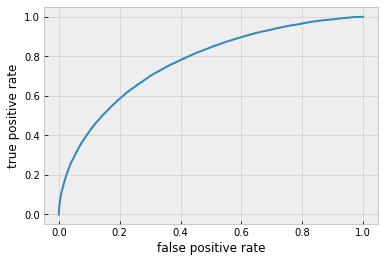

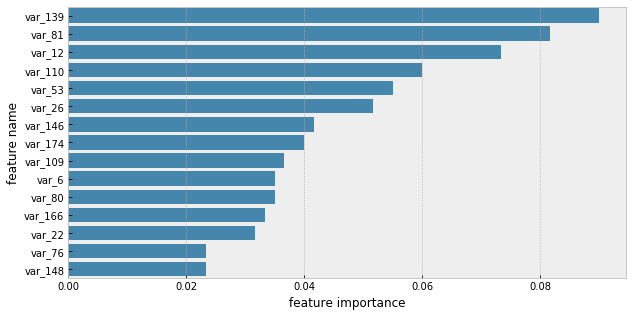

In [183]:
# fit model to ALL data (we have done CV already to check generalization; see above)
# this is the model we could use for evaluation on independent test set
model = model.fit(X, Y)

# predictions on full data set
Y_pred = model.predict(X)
Y_pred_proba = model.predict_proba(X)[:, 1]

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(Y, Y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

# print AUC
AUC = roc_auc_score(Y, Y_pred_proba)
print("AUC on full data set: {:.3f}".format(AUC))


###FEATURE IMPORTANCE###
feature_imp=pd.DataFrame({'feature name':X.columns, 
                          'feature importance':
                          model.feature_importances_}).sort_values('feature importance', ascending=False)

n_show=15
base_color = sns.color_palette()[0];

plt.figure(figsize = [10, n_show/3])
ax = sns.barplot(x = 'feature importance', 
                 y = 'feature name', 
                 data=feature_imp.iloc[:n_show, :], 
                 label='Feature Importance',
                 color=base_color)
ax.set_xlabel('feature importance');
# plt.tight_layout();
# plt.savefig('feature_importance_xgb_full.jpg', dpi=700);

## XGB with REDUCED data-set

In [184]:
# retrain model with 100 most important features from first run
most_important_feats = feature_imp['feature name'][0:100].tolist()
unimportant_feats = feature_imp.loc[~feature_imp['feature name'].isin(most_important_feats), 
                                    'feature name'].values.tolist()
# print top-3 features
print(most_important_feats[0:3])

# simplified data set
#train_X_simple = train_X[most_important_feats]
# dev_X_simple = dev_X[most_important_feats]
X_simple = X[most_important_feats]
X_simple.head()

['var_139', 'var_81', 'var_12']


var_139   var_81   var_12  var_110  var_53   var_26  var_146  \
ID_code                                                                 
train_0  15.6599  13.8372  14.0137   2.0323  5.1736  -5.1488  11.5659   
train_1  16.1622  18.1782  14.0239   6.6203  6.6885 -11.7684   8.9231   
train_2   8.6674  15.7811  14.1929   3.2304  6.4059  -7.9940  11.4934   
train_3   8.9821  10.5404  13.8463   4.2827  5.2091   0.8135  10.4994   
train_4  13.9547  13.3317  13.8481  -0.1937  5.7555   3.1736  11.5670   

         var_174  var_109   var_6   var_80  var_166   var_22   var_76  \
ID_code                                                                 
train_0  18.5618  24.3627  5.1187  13.6468   2.7004   2.5791  -2.3440   
train_1  30.2645  13.0858  5.6208   2.5462   3.2003   8.5524   3.2709   
train_2  25.6820  20.3882  6.9427   7.4729   3.2790   1.2145   4.5048   
train_3  14.7483  14.4135  5.8428   0.7839   2.5881   6.8202  11.6875   
train_4  18.4685  28.2749  5.9405   2.9598   3.2304  10.1102   1.0273   

         var_148  var_164  var_99  var_165    var_0  var_198  var_179  var_78  \
ID_code                                                                         
train_0   4.0288   6.6760 -3.4132  12.6644   8.9255  12.7803   1.7202  6.5199   
train_1   4.2578  -5.0121  0.6939  15.1345  11.5006  18.3560  11.0752  5.5075   
train_2   4.0714  -1.0410 -0.0269  20.5092   8.6093  14.7222   2.4013  6.3191   
train_3   3.7613 -11.0882  1.9480  17.2502  11.0604  17.9697   5.6961  4.0806   
train_4   3.7574   6.5769  0.6715  21.2607   9.8369  17.9974   5.1743  7.1734   

          var_44    var_2   var_13  var_133   var_21   var_40  var_170  \
ID_code                                                                  
train_0  11.6418  11.9081   0.5745   6.5674  16.2191  -5.2387  -4.7645   
train_1   1.2444  13.8588   8.4135   7.0513   2.7407 -11.1147   5.5378   
train_2   4.1006  12.0805   7.3124   6.6231  18.1377 -13.5174  -7.0927   
train_3   8.0485   8.9522  11.9704   7.1954  12.5579  -3.8294  -7.1541   
train_4   6.9087  12.8746   7.8895   6.6173  18.9608  -5.5963   1.4493   

         var_190  var_177   var_1   var_94  var_115  var_108   var_92  \
ID_code                                                                 
train_0   4.4354  13.7241 -6.7863  14.8421   1.5093  14.1104  11.0924   
train_1   7.6421  16.5721 -4.1473  11.7569   4.1569  13.9550   8.0905   
train_2   2.9057   8.8438 -2.7457  14.2621   2.9044  14.1963  14.1613   
train_3   4.4666  13.9552 -2.1518   7.2887  -2.5459  14.3256  14.4027   
train_4  -1.4905  13.5261 -1.4834  14.0553  -3.6135  14.0837   9.3627   

         var_191   var_34  var_123   var_33  var_154  var_135  var_137  \
ID_code                                                                  
train_0   3.9642  11.1920   0.7754  16.8911  10.4838   3.1345  31.4045   
train_1   7.7214  11.3702  10.1633  19.3710  -0.5687  -8.9921  18.1577   
train_2   9.7905  11.0449  -2.1746  19.0422  -5.1747 -11.7218  15.5827   
train_3   4.7433  10.6093  -8.2464   6.1796  17.0336   1.9586  24.6065   
train_4   9.5214  12.4057   9.7289  19.3239   4.7022   6.4730  25.8128   

         var_131  var_132  var_194  var_138  var_134  var_195  var_196  \
ID_code                                                                  
train_0   0.3587   9.6508  18.5227   2.8279   5.1726  -2.3978   7.8784   
train_1  -0.1780   5.7582  15.4305  -1.9721   1.9568   2.0339   8.1267   
train_2   0.0975   8.8186  21.6042   3.8212   3.9358   3.1417  -6.5213   
train_3   1.0486   8.9500  23.0347  -2.8233  -1.1984  -1.2706  -2.9275   
train_4   0.9442   7.7532  13.2876   2.6791  -6.8304  -1.5121   3.9267   

         var_136  var_197  var_130  var_185  var_124  var_129  var_128  \
ID_code                                                                  
train_0  29.4547   8.5635  12.8287   5.8764   4.2218  15.4462  -1.9245   
train_1   9.7797   8.7889  12.4205  -4.8622   0.1225  16.5346   0.8194   
train_2  24.5437   8.2675  11.5419  -5.3000   3.6932

In [185]:
# train model with simpliefied data
# compute results for different folds: check how general the model is
kfold = StratifiedKFold(n_splits=5, random_state=0)
scores = cross_val_score(model, X_simple, Y, cv=kfold, scoring='roc_auc', verbose=0)
mean_score = scores.mean()

# print XGB model
print(model)
print('---------------------------------------------------------------')

# print results
print('CV RESULTS:')
print('Average cross-validation AUC score: {:.3f}'.format(mean_score))
print('Std of cross-validation AUC score: {:.3f}'.format(scores.std()))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)
---------------------------------------------------------------
CV RESULTS:
Average cross-validation AUC score: 0.759
Std of cross-validation AUC score: 0.005


## XGB with GRID SEARCH and cross-validation

In [186]:
# define hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300], 
              'max_depth': [1, 3, 5],
              'scale_pos_weight': [1, 2, 4]}

# define the model
model_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=0)

# define grid search object
grid_search = RandomizedSearchCV(model_xgb, param_grid, scoring='roc_auc', 
                                 cv = 5, n_iter=12)

# training and CV
grid_search.fit(X, Y)

# print results 
cv_results = grid_search.cv_results_
xgb_best = grid_search.best_estimator_
print('Optimized model:\n', xgb_best)

Optimized model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=0, silent=True,
       subsample=1)


In [187]:
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print('average (5-fold) AUC: {:.4f}'.format(mean_score), 'with params:', params)

average (5-fold) AUC: 0.8402 with params: {'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 1}
average (5-fold) AUC: 0.8623 with params: {'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 3}
average (5-fold) AUC: 0.7856 with params: {'scale_pos_weight': 2, 'n_estimators': 100, 'max_depth': 1}
average (5-fold) AUC: 0.8792 with params: {'scale_pos_weight': 4, 'n_estimators': 300, 'max_depth': 5}
average (5-fold) AUC: 0.8479 with params: {'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 5}
average (5-fold) AUC: 0.8714 with params: {'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 5}
average (5-fold) AUC: 0.8393 with params: {'scale_pos_weight': 4, 'n_estimators': 300, 'max_depth': 1}
average (5-fold) AUC: 0.8740 with params: {'scale_pos_weight': 2, 'n_estimators': 300, 'max_depth': 3}
average (5-fold) AUC: 0.7858 with params: {'scale_pos_weight': 4, 'n_estimators': 100, 'max_depth': 1}
average (5-fold) AUC: 0.8718 with params: {'scale_pos_weight': 2, 'n_esti

In [188]:
cv_max_depth = [cv_results['params'][ii]['max_depth'] for ii in range(0, 12)]
cv_estimators = [cv_results['params'][ii]['n_estimators'] for ii in range(0, 12)]
cv_scale = [cv_results['params'][ii]['scale_pos_weight'] for ii in range(0, 12)]
cv_auc = cv_results['mean_test_score']

In [189]:
items = {'AUC' : pd.Series(data = cv_auc),
         'n_estimators' : pd.Series(data = cv_estimators),
         'max_depth' : pd.Series(data = cv_max_depth), 
         'scale_pos_weigth' : pd.Series(data = cv_scale)}
simple_df = pd.DataFrame(items)
simple_df = simple_df.sort_values(by=['AUC'], ascending=False)
simple_df.head()

AUC  max_depth  n_estimators  scale_pos_weigth
3   0.879210          5           300                 4
7   0.874036          3           300                 2
11  0.873901          3           300                 1
9   0.871764          5           200                 2
5   0.871352          5           200                 4

__OBSERVATIONS:__ 
- Best results for upper limit of n_estimators in search space (```n_estimators```=300); need to extend HPO search space. 
- Similary, highest AUC for largest tree depth (```max_depth```) and highest ```scale_pos_weigth```; try larger values as well. 

In [347]:
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

## XGB GRID-SEARCH by HAND

In [352]:
def get_metrics(y, pred):
    """
    function that prints several metrics:
    - accuracy
    - precision
    - recall
    - f1-score
    """
    
    # plot confusion matrix 
    print(confusion_matrix(y, pred))
    
    # print accuracy
    print('Accuracy score: {:.2f}%'.format(100*accuracy_score(y, pred)))

    # print precision
    print('Precision score: {:.2f}%'.format(100*precision_score(y, pred)))
    
    # print recall
    print('Recall score: {:.2f}%'.format(100*recall_score(y, pred)))
    
    # print f1-score
    print('F-1 score: {:.2f}%'.format(100*f1_score(y, pred)))

n_estimators: 400 , scale_pos_weigth: 1 , max_depth: 5
Cross-validation AUC scores: [0.88219659 0.87968196 0.88634735 0.88515723 0.88868938]
Average cross-validation AUC score: 0.8844
Std cross-validation AUC score: 0.0032
Predictions FULL TRAINING SET:
AUC on full data set: 0.970


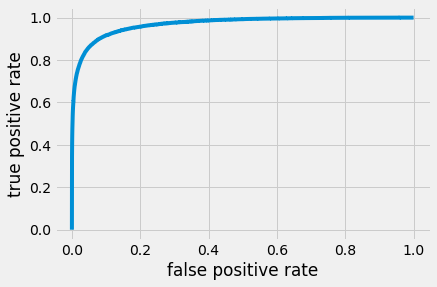

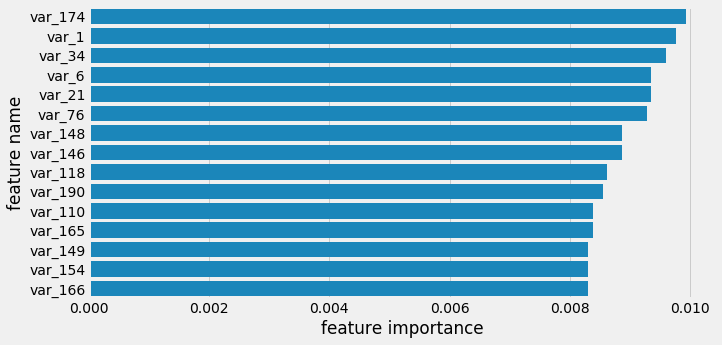

n_estimators: 400 , scale_pos_weigth: 1 , max_depth: 7
Cross-validation AUC scores: [0.8762069  0.87611101 0.88242746 0.88023085 0.88213322]
Average cross-validation AUC score: 0.8794
Std cross-validation AUC score: 0.0028
Predictions FULL TRAINING SET:
AUC on full data set: 0.998


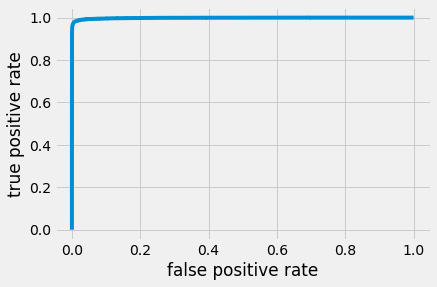

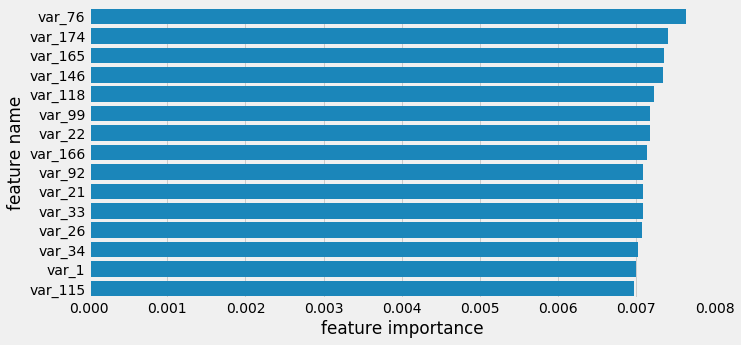

n_estimators: 400 , scale_pos_weigth: 10 , max_depth: 5
Cross-validation AUC scores: [0.88219659 0.87968196 0.88634735 0.88515723 0.88868938]
Average cross-validation AUC score: 0.8844
Std cross-validation AUC score: 0.0032
Predictions FULL TRAINING SET:
AUC on full data set: 0.970


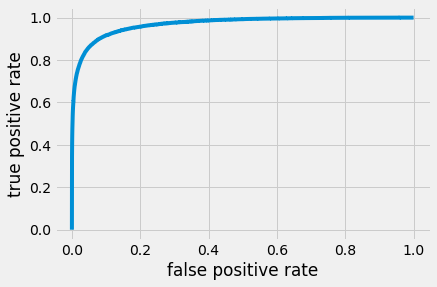

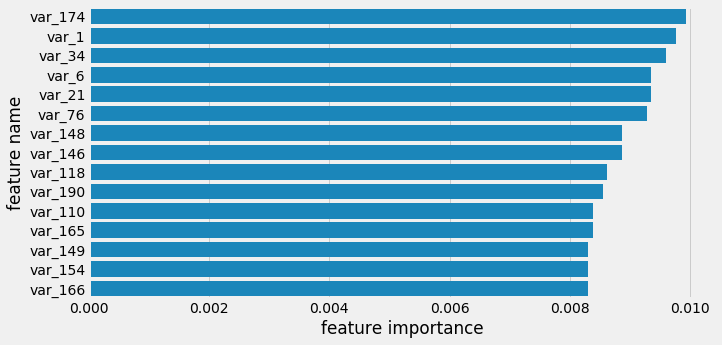

n_estimators: 400 , scale_pos_weigth: 10 , max_depth: 7
Cross-validation AUC scores: [0.8762069  0.87611101 0.88242746 0.88023085 0.88213322]
Average cross-validation AUC score: 0.8794
Std cross-validation AUC score: 0.0028
Predictions FULL TRAINING SET:
AUC on full data set: 0.998


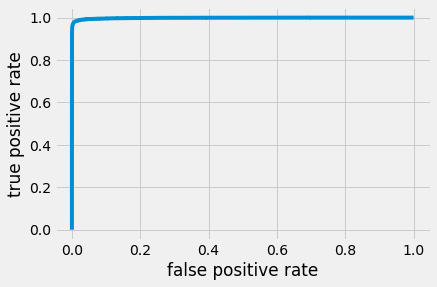

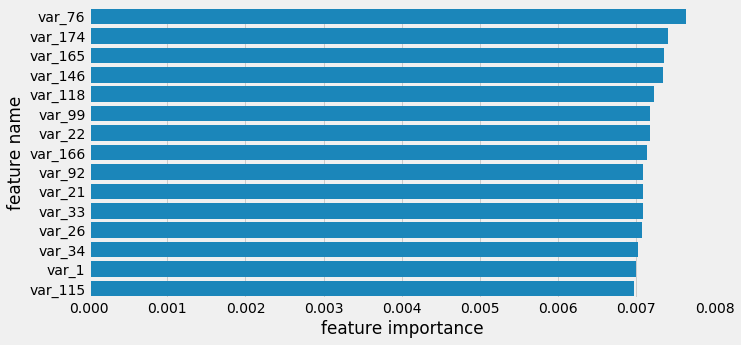

n_estimators: 500 , scale_pos_weigth: 1 , max_depth: 5
Cross-validation AUC scores: [0.88462526 0.88212938 0.88832351 0.88703915 0.89068236]
Average cross-validation AUC score: 0.8866
Std cross-validation AUC score: 0.0030
Predictions FULL TRAINING SET:
AUC on full data set: 0.977


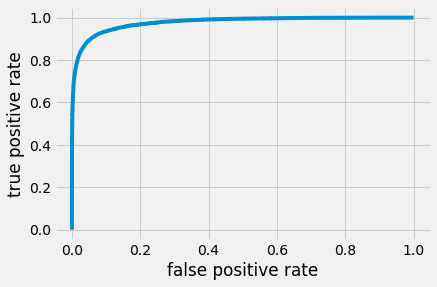

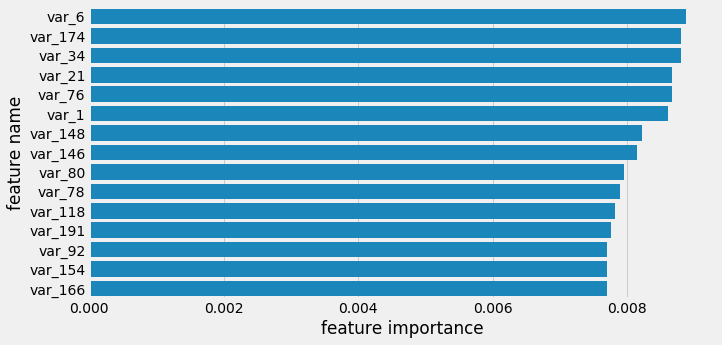

n_estimators: 500 , scale_pos_weigth: 1 , max_depth: 7
Cross-validation AUC scores: [0.87712423 0.87680673 0.88296694 0.88091842 0.88287327]
Average cross-validation AUC score: 0.8801
Std cross-validation AUC score: 0.0027
Predictions FULL TRAINING SET:
AUC on full data set: 0.999


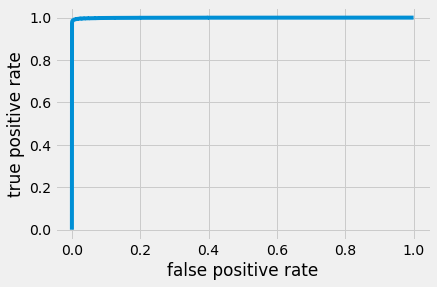

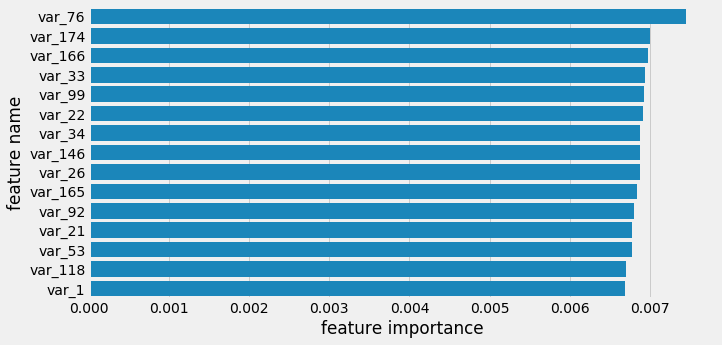

n_estimators: 500 , scale_pos_weigth: 10 , max_depth: 5
Cross-validation AUC scores: [0.88462526 0.88212938 0.88832351 0.88703915 0.89068236]
Average cross-validation AUC score: 0.8866
Std cross-validation AUC score: 0.0030
Predictions FULL TRAINING SET:
AUC on full data set: 0.977


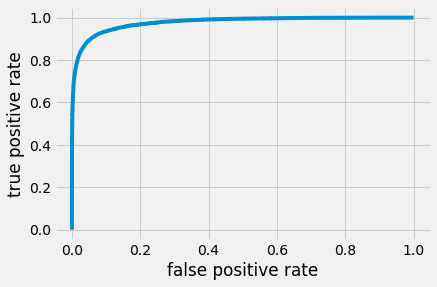

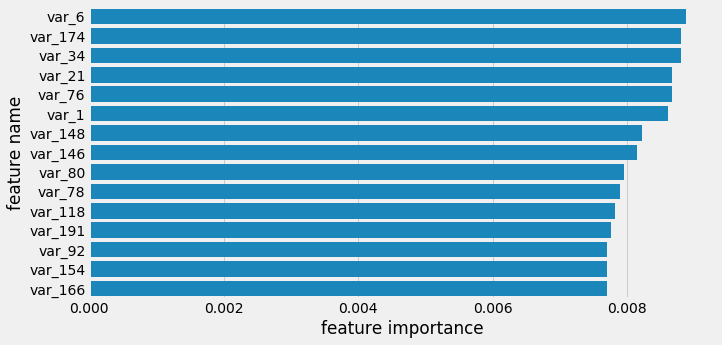

n_estimators: 500 , scale_pos_weigth: 10 , max_depth: 7
Cross-validation AUC scores: [0.87712423 0.87680673 0.88296694 0.88091842 0.88287327]
Average cross-validation AUC score: 0.8801
Std cross-validation AUC score: 0.0027


In [ ]:
# GRID SEARCH (by hand): perform grid search to find optimized hyperparameters
# for every set of hyperparameters we perform crossvalidation to check generalization
# store best model based on average AUC based on startified k-fold
# then fit model to all data, should improve model performance on unseen test data

best_score=0

# cross-validation
for n_estimators in [400, 500]:
    for scale_pos_weigth in [1, 10]:
        for max_depth in [5, 7]:
        
            # define the model
            model = xgb.XGBClassifier(objective='binary:logistic', seed=0,
                                      n_estimators=n_estimators, 
                                      max_depth=max_depth,
                                      scale_pos_weigth=scale_pos_weigth)

            # compute results for different folds: check how general the model is
            kfold = StratifiedKFold(n_splits=5, random_state=42)
            scores = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc')
            mean_score = scores.mean()
            std_score = scores.std()

            # print K-FOLD results
            print('n_estimators:', n_estimators,', scale_pos_weigth:', 
                  scale_pos_weigth, ', max_depth:', max_depth)
            print('Cross-validation AUC scores: {}'.format(scores))
            print('Average cross-validation AUC score: {:.4f}'.format(mean_score))
            print('Std cross-validation AUC score: {:.4f}'.format(std_score))

            # store best set of parameters
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_estimators': n_estimators, 
                               'scale_pos_weigth': scale_pos_weigth,
                               'max_depth': max_depth}
                best_model = model

            
            # fit model to ALL data (we have done CV already to check generalization)
            model = model.fit(X,Y)
            
            # predictions on full data set
            Y_pred = model.predict(X)
            Y_pred_proba = model.predict_proba(X)[:, 1]

            ###METRICS###
            # print accuracies FULL TRAINING set
            print('Predictions FULL TRAINING SET:')
            # get_metrics(Y, Y_pred)
            # print('')

            # Plot ROC Curve
            fpr, tpr, thresholds = roc_curve(Y, Y_pred_proba)
            plt.plot(fpr, tpr)
            plt.xlabel('false positive rate')
            plt.ylabel('true positive rate')

            # print AUC
            AUC = roc_auc_score(Y, Y_pred_proba)
            print("AUC on full data set: {:.3f}".format(AUC))


            ###FEATURE IMPORTANCE###
            feature_imp=pd.DataFrame({'feature name':X.columns, 
                                      'feature importance':
                                      model.feature_importances_}).sort_values('feature importance', ascending=False)
                                                                                                
            n_show=15
            base_color = sns.color_palette()[0];

            plt.figure(figsize = [10, n_show/3])
            ax = sns.barplot(x = 'feature importance', 
                             y = 'feature name', 
                             data=feature_imp.iloc[:n_show, :], 
                             label='Feature Importance',
                             color=base_color)
            ax.set_xlabel('feature importance')
            plt.show()
            
    
print('Best model:', best_model)  

__OBSERVATIONS:__ 
- Best results (__AUC=0.8866__ in 5-fold CV) for ```max_depth```=5 and largest number of estimators tested, ```n_estimators```=500. 
- Try larger values for ```n_estimators```.

### XGB HPO-MODEL: Test inference and submission

In [ ]:
# fit model to ALL data (we have done CV already to check generalization; see above)
# this is the model we could use for evaluation on independent test set
best_model = best_model.fit(X, Y)

In [ ]:
# inference on test set
Y_prob_test = best_model.predict_proba(X_test)[:,1]

sample_submission['target'] = Y_prob_test
sample_submission.to_csv('submission_xgb_hpo_1.csv', index=False)

# load and show
results_xgb1 = pd.read_csv('submission_xgb_hpo_1.csv')
results_xgb1.head()

In [ ]:
# check number of positive predictions in test set for threshold=0.5
number_pos_percent = np.round(results_xgb1['target']).sum()/len(results_xgb1)*100
print('Percent of predicted positive in test (XGB): {:.2f}%'.format(number_pos_percent))

## XGB: SYSTEMATIC FUNCTION

In [ ]:
def build_and_fit_xgb(X_train, Y_train, X_dev, Y_dev, 
                      n_estimators=100, max_features=None, max_depth=3):
    """
    function to build and train gradient-boost model
    """
    
    ###MODEL###
    # define the model with hyperparameters
    model = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=n_estimators,
                              max_features = max_features, 
                              max_depth = max_depth,
                              seed=0)
    
    # LIST OF PARAMETERS :
    # max_depth=3, learning_rate=0.1, n_estimators=100, silent=True,
    # objective='binary:logistic', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0,
    # subsample=1, colsample_bytree=1, base_score=0.5, seed=0, missing=None
    
    # train the model
    model.fit(X_train, Y_train)
    
    # predictions training-set
    Y_train_pred = model.predict(X_train)
    Y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # predictions dev-set
    Y_dev_pred = model.predict(X_dev)
    Y_dev_pred_proba = model.predict_proba(X_dev)[:, 1]

    
    ###METRICS###
    # print accuracies TRAINING set
    print('Predictions TRAINING SET:')
    get_metrics(Y_train, Y_train_pred)
    print('')
    
    # print accuracies DEV set
    print('Predictions DEV SET:')
    get_metrics(Y_dev, Y_dev_pred)
    print('')
    
    # print number of true positives and positive predictions
    print('Number of true positives (Y=1) in dev set:', Y_dev.sum())
    print('Number of predicted positives (Y=1) in dev set:', Y_dev_pred.sum())

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_dev, Y_dev_pred_proba)
    plt.plot(fpr, tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    
    # print AUC
    AUC = roc_auc_score(Y_dev, Y_dev_pred_proba)
    print("AUC on dev set: {:.3f}".format(AUC))
    
    
    ###FEATURE IMPORTANCE###
    feature_imp=pd.DataFrame({'feature name':X_train.columns, 
                              'feature importance':model.feature_importances_}).sort_values('feature importance', 
                                                                                            ascending=False)
    n_show=15
    base_color = sns.color_palette()[0];

    plt.figure(figsize = [10, n_show/3])
    ax = sns.barplot(x = 'feature importance', 
                     y = 'feature name', 
                     data=feature_imp.iloc[:n_show, :], 
                     label='Feature Importance',
                     color=base_color)
    ax.set_xlabel('feature importance')
    plt.show()

    
    return model, feature_imp

In [ ]:
# XGB model with standard hyperparameters
model, feature_imp = build_and_fit_xgb(train_X, train_y, dev_X, dev_y)

## XGB: HPO with Bayesian Optimization

This is __work in progress__.

In [349]:
# set number of evaluations and number of folds
MAX_EVALS = 30
N_FOLDS = 5
ITER = 0

In [351]:
# Model with default hyperparameters
xgb_default = xgb.XGBClassifier()
print('XBG default model:', xgb_default)

XBG default model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [353]:
# split training data set into training (0.8) and dev set (0.2)
train_set, dev_set = train_test_split(train.set_index(['ID_code']), test_size=0.2, random_state=123)

labels = train_set['target']
features = train_set.drop(['target'], axis=1)

test_labels = dev_set['target']
test_features = dev_set.drop(['target'], axis=1)

In [357]:
# Create a XGB dataset
train_set = xgb.DMatrix(features, label = labels)

In [360]:
# XGB parameters
param_xgb={'colsample_bytree': 0.6610091147584736,
 'gamma': 0.17518262050718658,
 'learning_rate': 0.09655034655786202,
 'max_depth': 2,
 'n_estimators': 1729,
 'reg_alpha': 0.8084226529621341,
 'reg_lambda': 1.3917111079983842,
 'scale_pos_weight': 0.9512559898653261,
 'subsample': 0.673790607576246}

In [363]:
cv_results = xgb.cv(params = param_xgb, dtrain = train_set, num_boost_round = 10000, nfold = 5, 
                    early_stopping_rounds = 100, metrics = 'auc', seed = 50)

[22:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:34:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:34:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:36:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:37:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:52:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:53:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:54:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:55:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[22:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:01:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:02:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:08:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:11:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:12:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:12:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:12:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:14:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:14:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:16:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:16:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:18:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:18:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:19:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[23:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:21:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:21:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:22:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:34:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:35:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:35:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:35:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[23:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:51:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:53:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:54:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:55:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:56:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:56:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:57:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:57:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[23:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:58:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[23:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[23:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

In [ ]:
def objective_xgb(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITER
    
    ITER += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = xgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

## XGB: Alternative Bayesian Optimization

https://www.kaggle.com/mohanamurali/xgboost-bayesian-optimisation

-----

# GRADIENT BOOSTED MODEL (LGBM)

https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Bayesian%20Hyperparameter%20Optimization%20of%20Gradient%20Boosting%20Machine.ipynb

In [217]:
MAX_EVALS = 30
N_FOLDS = 10

In [197]:
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [208]:
train_set, dev_set = train_test_split(train.set_index(['ID_code']), test_size=0.2, random_state=123)

labels = train_set['target']
features = train_set.drop(['target'], axis=1)

test_labels = dev_set['target']
test_features = dev_set.drop(['target'], axis=1)

## LGBM: RANDOM SEARCH

In [199]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

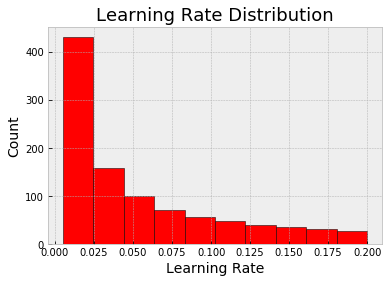

In [200]:
# plot learning rate grid
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); 
plt.ylabel('Count', size = 14); 
plt.title('Learning Rate Distribution', size = 18);

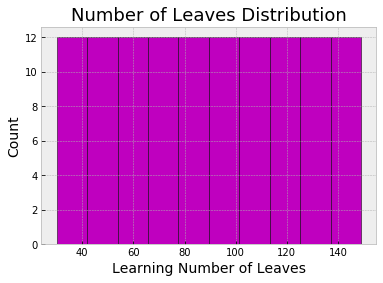

In [201]:
# plot distribution of number of leaves
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); 
plt.ylabel('Count', size = 14); 
plt.title('Number of Leaves Distribution', size = 18);

In [205]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7333333333333333,
 'learning_rate': 0.0461716637960089,
 'min_child_samples': 295,
 'num_leaves': 83,
 'reg_alpha': 0.5918367346938775,
 'reg_lambda': 0.8979591836734693,
 'subsample_for_bin': 100000}

To add a subsample ratio if the boosting_type is not goss, we can use an if statement.

In [206]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7333333333333333,
 'learning_rate': 0.0461716637960089,
 'min_child_samples': 295,
 'num_leaves': 83,
 'reg_alpha': 0.5918367346938775,
 'reg_lambda': 0.8979591836734693,
 'subsample': 0.98989898989899,
 'subsample_for_bin': 100000}

We set the subsample to 1.0 if boosting type is goss which is the same as not using any subsampling. (Subsampling is when we train on a subset of the rows (observations) rather than all of them. This technique is also referred to as bagging for "bootstrap aggregating").

### Cross Validation with Early Stopping in LightGBM

- The scikit-learn cross validation api does not include the option for early stopping. 
- Therefore, we will use the LightGBM cross validation function with 100 early stopping rounds. 
- To use this function, we need to create a dataset from our features and labels.

In [209]:
# Create a lgb dataset
train_set = lgb.Dataset(features, label = labels)

The cv function takes in the parameters, the training data, the number of training rounds, the number of folds, the metric, the number of early stopping rounds, and a few other arguments. We set the number of boosting rounds very high, but we will not actually train this many estimators because we are using early stopping to stop training when the validation score has not improved for 100 estimators.

In [210]:
# Perform cross validation with 8 folds
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 8, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.88668 with std of 0.00358.
The ideal number of iterations was 608.


We have our domain and our algorithm which in this case is random selection. The other two parts we need for an optimization problem are an objective function and a data structure to keep track of the results (these four parts will also be required in Bayesian Optimization).

In [211]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

### Objective Function

In [212]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

### LGB: Random Search Implementation

In [ ]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [219]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

loss                                             params iteration  \
0   0.10883  {'min_child_samples': 455, 'verbose': 1, 'cols...        16   
1  0.109044  {'min_child_samples': 90, 'verbose': 1, 'colsa...        15   
2  0.111237  {'min_child_samples': 460, 'verbose': 1, 'cols...         5   
3  0.111913  {'min_child_samples': 395, 'verbose': 1, 'cols...         9   
4  0.114622  {'min_child_samples': 425, 'verbose': 1, 'cols...         3   

  estimators     time  
0       5692  4903.72  
1       9998  3406.79  
2       9195  46347.5  
3        868  1136.22  
4       1045  4770.41

In [220]:
# best hyperparameters
random_results.loc[0, 'params']

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8222222222222222,
 'learning_rate': 0.005304306643546163,
 'metric': 'auc',
 'min_child_samples': 455,
 'num_leaves': 94,
 'reg_alpha': 0.9591836734693877,
 'reg_lambda': 0.22448979591836732,
 'subsample': 0.9545454545454546,
 'subsample_for_bin': 200000,
 'verbose': 1}

In [221]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.8953 on the test data.
This was achieved using 16 search iterations.


## LGBM: Bayesian Hyperparameter Optimization using Hyperopt

In [236]:
MAX_EVALS = 20
N_FOLDS = 5

In [237]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [238]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

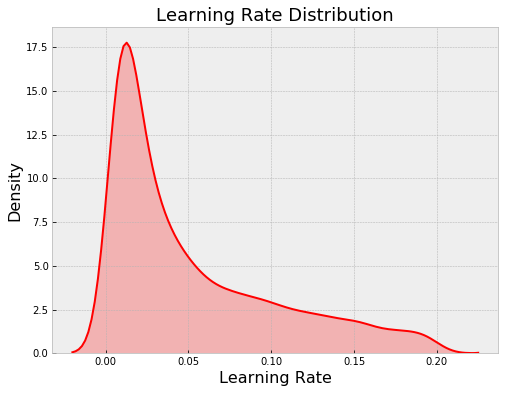

In [239]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

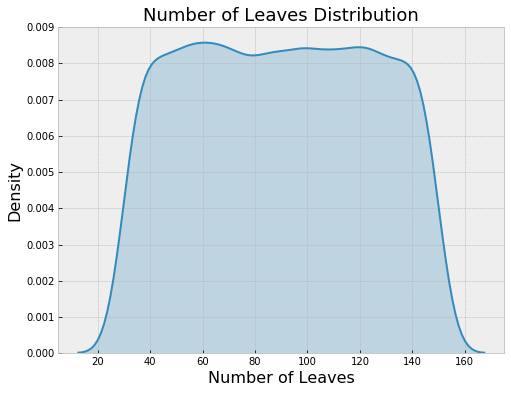

In [240]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [241]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.5078004920171227}}

In [242]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'dart', 'subsample': 0.5078004920171227}

In [243]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [244]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.9785886172370031,
 'learning_rate': 0.02289859632711885,
 'min_child_samples': 375.0,
 'num_leaves': 102.0,
 'reg_alpha': 0.8151744573008642,
 'reg_lambda': 0.37934923378311125,
 'subsample': 1.0,
 'subsample_for_bin': 280000.0}

In [245]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8954364349296633,
 'learning_rate': 0.044164052756213046,
 'min_child_samples': 440.0,
 'num_leaves': 49.0,
 'reg_alpha': 0.240956235873648,
 'reg_lambda': 0.1699570420810811,
 'subsample': 1.0,
 'subsample_for_bin': 160000.0}

In [246]:
# optimization algorithm
tpe_algorithm = tpe.suggest

In [247]:
# Keep track of results
bayes_trials = Trials()

In [248]:
# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [249]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [250]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 2891,
  'iteration': 10,
  'loss': 0.10886015952072814,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.7326787636533016,
   'learning_rate': 0.017532163285674928,
   'metric': 'auc',
   'min_child_samples': 420,
   'num_leaves': 34,
   'reg_alpha': 0.78739503162987,
   'reg_lambda': 0.5520827853417427,
   'subsample': 0.5140566400846498,
   'subsample_for_bin': 220000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 525.5219607900362},
 {'estimators': 3122,
  'iteration': 5,
  'loss': 0.10915188453391611,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.620649129448606,
   'learning_rate': 0.017934544496484815,
   'metric': 'auc',
   'min_child_samples': 260,
   'num_leaves': 30,
   'reg_alpha': 0.2092981310373776,
   'reg_lambda': 0.8946886330215067,
   'subsample': 0.8731487506937664,
   'subsample_for_bin': 20000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 418.636258878

In [251]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

loss                                             params  iteration  \
0  0.108860  {'min_child_samples': 420, 'verbose': 1, 'cols...         10   
1  0.109152  {'min_child_samples': 260, 'verbose': 1, 'cols...          5   
2  0.111573  {'min_child_samples': 475, 'verbose': 1, 'cols...          9   
3  0.111909  {'min_child_samples': 225, 'verbose': 1, 'cols...         15   
4  0.112888  {'min_child_samples': 225, 'verbose': 1, 'cols...         14   

   estimators   train_time  
0        2891   525.521961  
1        3122   418.636259  
2        2556  3846.385729  
3         888   236.376348  
4        3966  7255.018688

For some reason, when we save to a file and then read back in, the dictionary of hyperparameters is represented as a ``string``. To convert from a string back to a dictionary we can use the ```ast``` library and the ``literal_eval`` function.

In [252]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7326787636533016,
 'learning_rate': 0.017532163285674928,
 'metric': 'auc',
 'min_child_samples': 420,
 'num_leaves': 34,
 'reg_alpha': 0.78739503162987,
 'reg_lambda': 0.5520827853417427,
 'subsample': 0.5140566400846498,
 'subsample_for_bin': 220000,
 'verbose': 1}

In [253]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.7326787636533016,
        learning_rate=0.017532163285674928, max_depth=-1, metric='auc',
        min_child_samples=420, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2891, n_jobs=-1, num_leaves=34, objective='binary',
        random_state=50, reg_alpha=0.78739503162987,
        reg_lambda=0.5520827853417427, silent=True,
        subsample=0.5140566400846498, subsample_for_bin=220000,
        subsample_freq=0, verbose=1)

In [256]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations.'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.89497 AUC ROC on the test set.
This was achieved after 10 search iterations.


## LGBM: Bayesian Hyperparameter Optimization vs Random Search

Comparing the results to random seach both in numbers and figures can help us understand how Bayesian Optimization searches work. First, we can look at the best hyperparameters (as determined from the validation error) from both searches.

In [260]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'
best_params = pd.DataFrame(best_bayes_params, index = [0]).append(pd.DataFrame(best_random_params, index = [0]), 
                                                                  ignore_index = True, sort = True)
best_params

boosting_type class_weight  colsample_bytree  learning_rate  \
0          gbdt     balanced          0.732679       0.017532   
1          gbdt         None          0.822222       0.005304   

                  method metric  min_child_samples  num_leaves  reg_alpha  \
0  Bayesian optimization    auc                420          34   0.787395   
1          random search    auc                455          94   0.959184   

   reg_lambda  subsample  subsample_for_bin  verbose  
0    0.552083   0.514057             220000        1  
1    0.224490   0.954545             200000        1

In [265]:
# Create a new dataframe for storing parameters
random_results = random_results.dropna()
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                             index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

min_child_samples verbose colsample_bytree learning_rate num_leaves  \
0               455       1         0.822222    0.00530431         94   
1                90       1         0.644444    0.00520727         46   
2               460       1         0.911111    0.00805087        109   
3               395       1         0.866667     0.0298637        136   
4               425       1         0.644444     0.0685437        135   

  subsample boosting_type metric reg_alpha reg_lambda class_weight  \
0  0.954545          gbdt    auc  0.959184    0.22449         None   
1   0.69697          gbdt    auc  0.857143   0.204082         None   
2  0.575758          dart    auc  0.755102   0.346939         None   
3  0.868687          gbdt    auc  0.877551   0.836735         None   
4  0.777778          dart    auc  0.102041    0.77551     balanced   

  subsample_for_bin      loss iteration  
0            200000   0.10883        16  
1             20000  0.109044        15  
2            200000  0.111237         5  
3            240000  0.111913         9  
4            220000  0.114622         3

In [266]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

min_child_samples verbose colsample_bytree learning_rate num_leaves  \
0               420       1         0.732679     0.0175322         34   
1               260       1         0.620649     0.0179345         30   
2               475       1         0.667308     0.0401189         70   
3               225       1         0.622008     0.0356515         70   
4               225       1         0.912423     0.0191997        102   

  subsample boosting_type metric reg_alpha reg_lambda class_weight  \
0  0.514057          gbdt    auc  0.787395   0.552083     balanced   
1  0.873149          gbdt    auc  0.209298   0.894689         None   
2  0.998529          dart    auc   0.86951   0.440767         None   
3  0.766181          gbdt    auc  0.410074   0.452761         None   
4  0.756071          dart    auc  0.191643   0.689694     balanced   

  subsample_for_bin      loss  iteration  
0            220000  0.108860         10  
1             20000  0.109152          5  
2            160000  0.111573          9  
3            280000  0.111909         15  
4            200000  0.112888         14

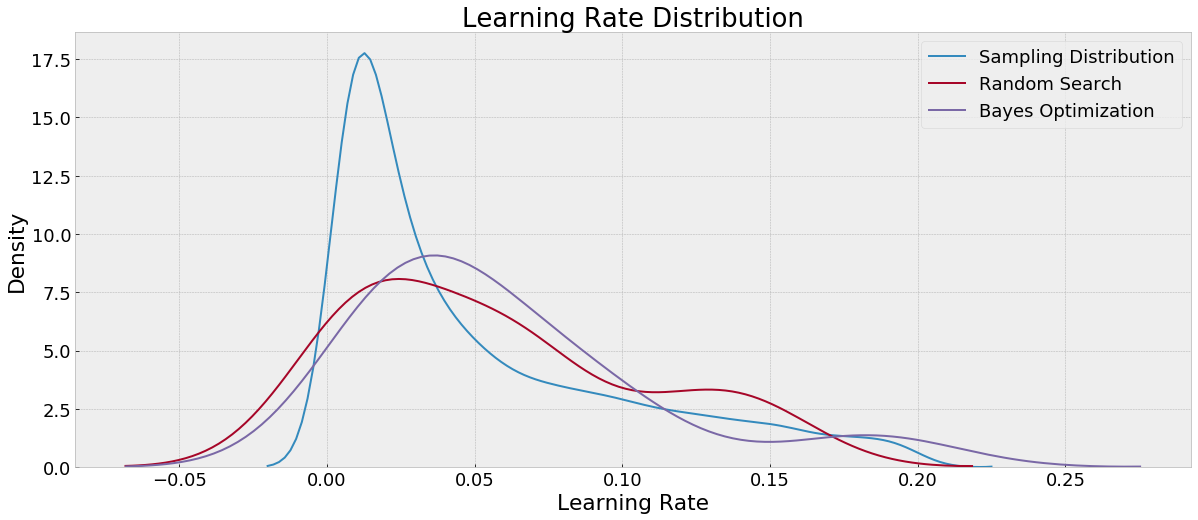

In [267]:
# PLOT learning rates
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

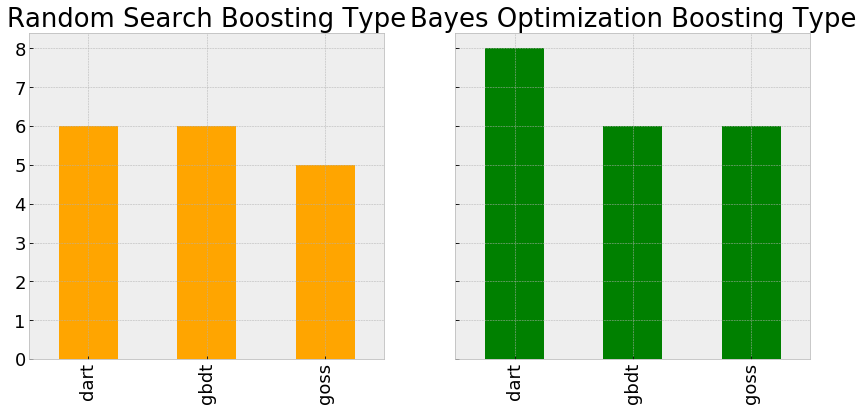

In [268]:
# PLOT boosting type
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [269]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

Random Search boosting type percentages


gbdt    35.294118
goss    35.294118
dart    29.411765
Name: boosting_type, dtype: float64

In [270]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Bayes Optimization boosting type percentages


dart    40.0
gbdt    30.0
goss    30.0
Name: boosting_type, dtype: float64

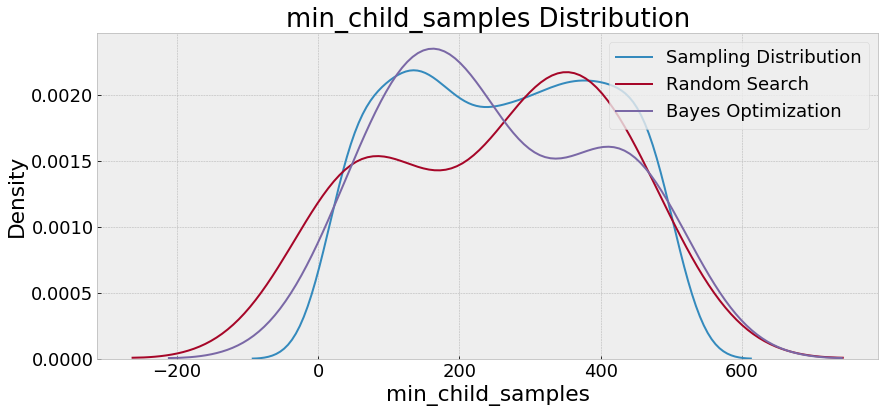

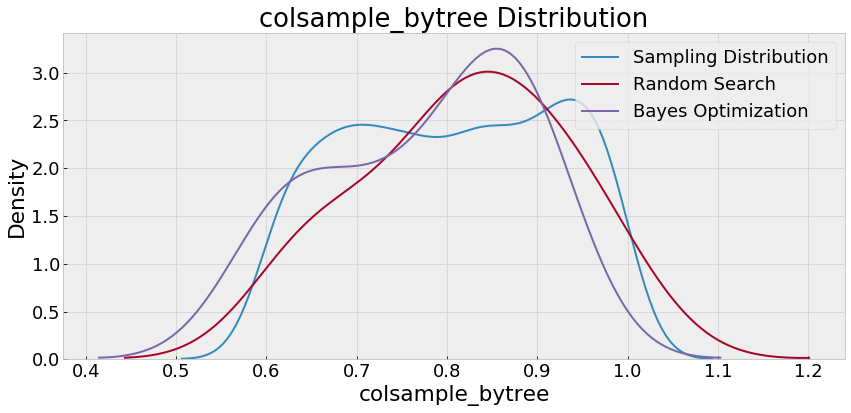

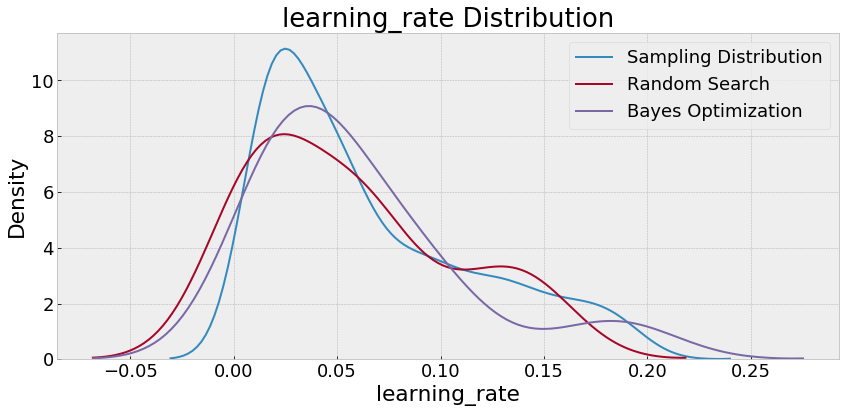

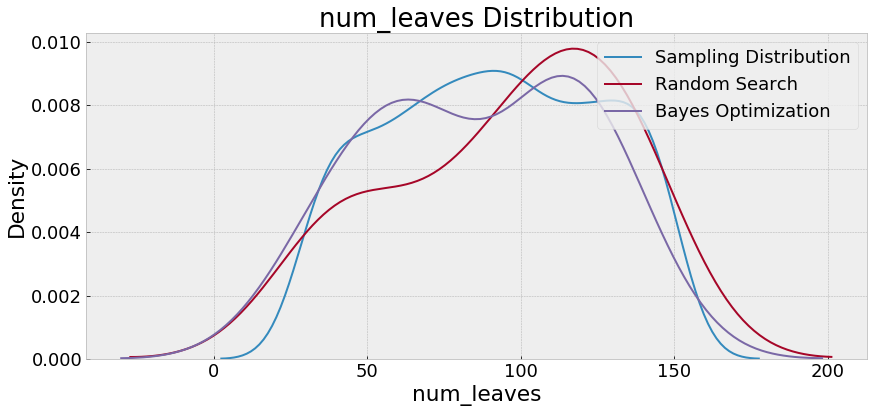

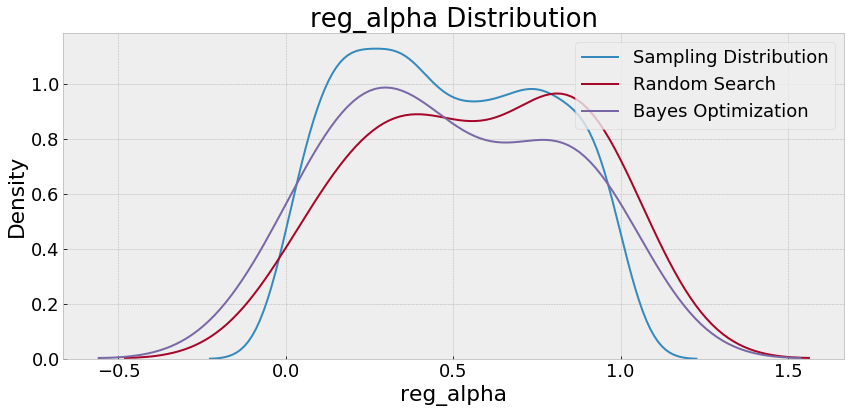

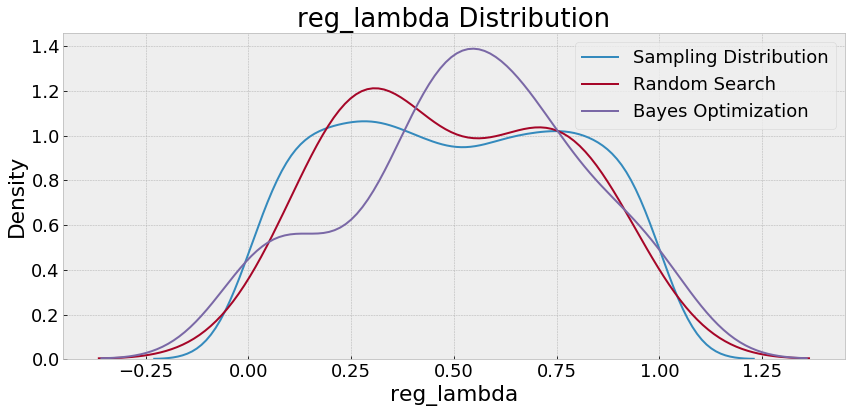

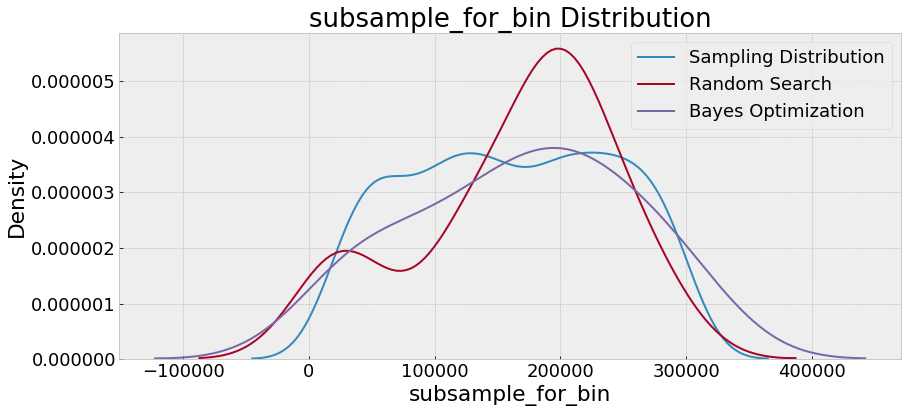

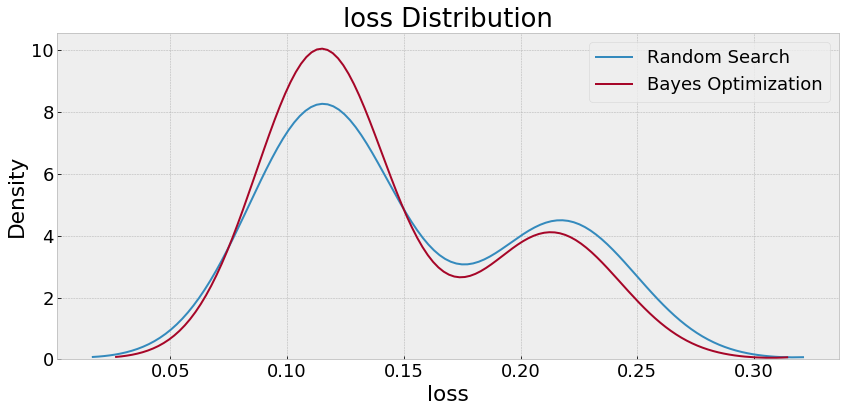

In [271]:
# PLOT all numeric hyperparameters
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();


### Evolution of Hyperparameters Searched

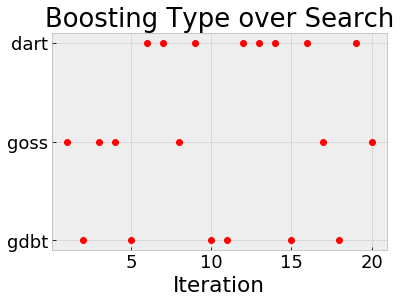

In [272]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

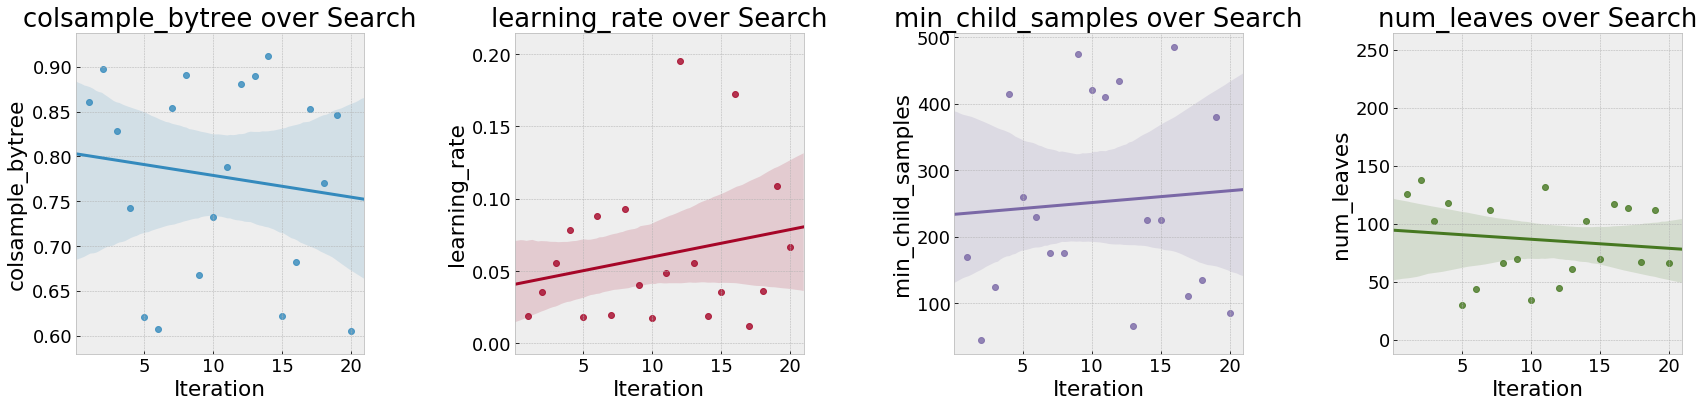

In [273]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

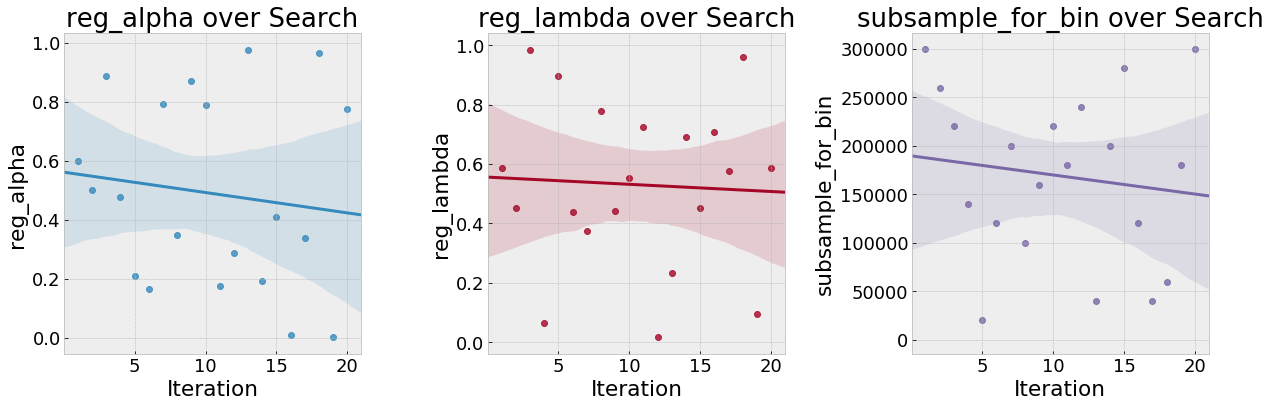

In [274]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

#### Validation Losses
Finally, we can look at the losses recorded by both random search and Bayes Optimization. We would expect the average loss recorded by Bayes Optimization to be lower because this method should spend more time in promising regions of the search space.

In [275]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

ROC AUC  iteration  search
0  0.891170         16  random
1  0.890956         15  random
2  0.888763          5  random
3  0.888087          9  random
4  0.885378          3  random

In [280]:
# sort by ROC AUC
scores = scores.sort_values(by='ROC AUC', ascending = False)
scores.head()

ROC AUC  iteration  search
0  0.891170         16  random
0  0.891140         10   Bayes
1  0.890956         15  random
1  0.890848          5   Bayes
2  0.888763          5  random

We can make histograms of the scores (not taking in account the iteration) on the same x-axis scale to see if there is a difference in scores.

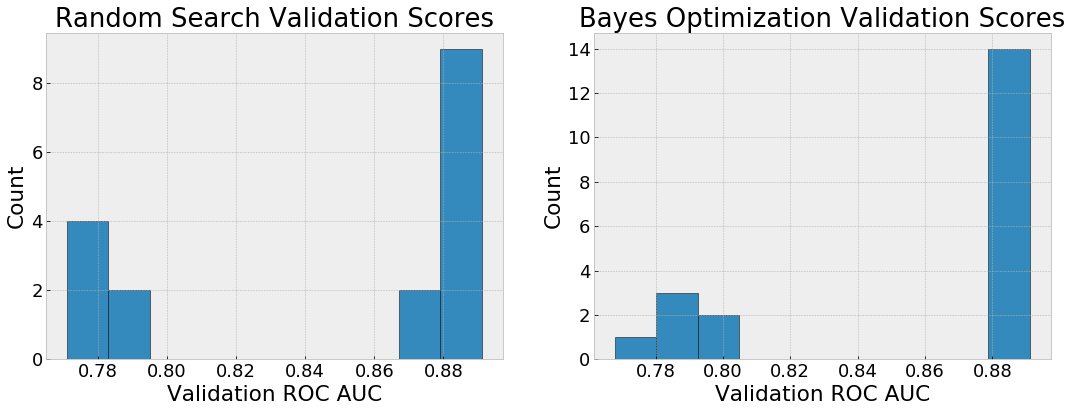

In [281]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
#plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
#plt.xlim(0.75, 0.78);


Bayesian optimization should get better over time. Let's plot the scores against the iteration to see if there was improvement.

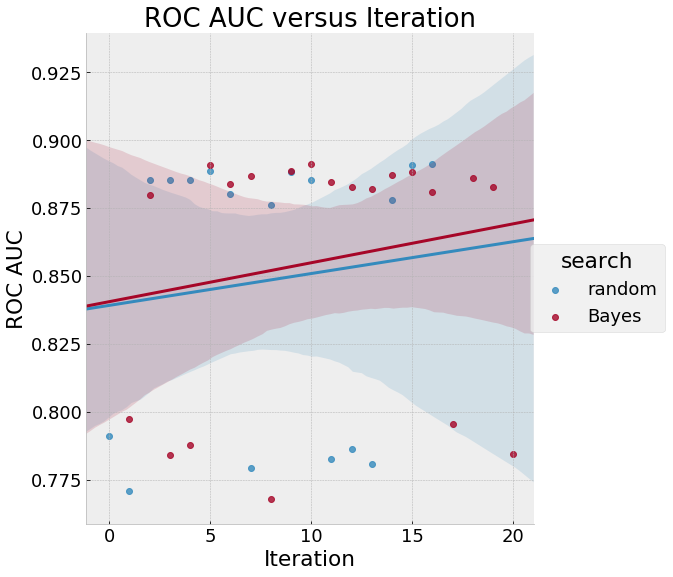

In [282]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

In [284]:
# Save the trial results
with open('results/trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

In [285]:
# Save dataframes of parameters
bayes_params.to_csv('results/bayes_params.csv', index = False)
random_params.to_csv('results/random_params.csv', index = False)

## LGBM: Test inference and submission

In [292]:
# inference on test set
Y_prob_test = best_bayes_model.predict_proba(X_test)[:, 1]

sample_submission['target'] = Y_prob_test
sample_submission.to_csv('submission_lgbm_1.csv', index=False)

# load and show
results_lgbm = pd.read_csv('submission_lgbm_1.csv')
results_lgbm.head()

# check number of positive predictions in test set for threshold=0.5
number_pos_percent = np.round(results_lgbm['target']).sum()/len(results_lgbm)*100
print('Percent of predicted positive in test (LGBM): {:.2f}%'.format(number_pos_percent))

Percent of predicted positive in test (LGBM): 14.77%


## LGBM: Continued Search with Bayesian Hyperparameter Optimization

- We can keep running the Bayesian hyperparameter search for more iterations to try for better results. Hyperopt will continue searching where it left off if we pass it a trials object that already has information on previous runs. This raises a good point: always save your previous results, because you never know when they will be useful!

- Another interesting point to not is that Bayesian Optimization methods do not have any internal state which means all they need are the results: previous inputs to the objective function and the resulting loss. Based only on these results, these methods can construct a surrogate function and suggest the next set of hyperparameters to evaluate. The internals of the objective function have no effect on the Bayesian Optimization method hence the naming of this as a black box optimization method.

In [ ]:
# Continue training
ITERATION = MAX_EVALS + 1

# Set more evaluations
MAX_EVALS = 30

In [ ]:
%%capture

# Use the same trials object to keep training
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1, rstate = np.random.RandomState(50))

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [ ]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

In [ ]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

-----

# BLENDING OF DIFFERENT MODELS

In [307]:
def hybrid_prediction(data1, data2, weight1=0.5, filename='hybrid'):
    """
    combine predictions of two models into averaged prediction 
    with parameter weight1 given to first set of results
    """
    
    data1 = data1.rename(columns = {'target': 'target1'})
    data2 = data2.rename(columns = {'target': 'target2'})
    
    # average results
    hybrid = data1.merge(data2, how='left', on='ID_code')
    
    hybrid['target'] = weight1*hybrid['target1'] + (1-weight1)*hybrid['target2']    
    hybrid.drop('target1', axis=1, inplace=True)
    hybrid.drop('target2', axis=1, inplace=True)
        
    # submission file
    submission_name = (filename + '.csv')
    hybrid.to_csv(submission_name, index=False)
    
    return hybrid


In [12]:
def hybrid_prediction3(data1, data2, data3, weight1=1/3, weight2=1/3, filename='hybrid'):
    """
    combine predictions of two models into averaged prediction 
    with parameter weight1 given to first set of results
    """
    
    data1 = data1.rename(columns = {'target': 'target1'})
    data2 = data2.rename(columns = {'target': 'target2'})
    data3 = data3.rename(columns = {'target': 'target3'})
    
    # average results
    hybrid = data1.merge(data2, how='left', on='ID_code')
    hybrid = hybrid.merge(data3, how='left', on='ID_code')
    
    hybrid['target'] = weight1*hybrid['target1'] + weight2*hybrid['target2'] + (1-weight1-weight2)*hybrid['target3'] 
    hybrid.drop('target1', axis=1, inplace=True)
    hybrid.drop('target2', axis=1, inplace=True)
    hybrid.drop('target3', axis=1, inplace=True)
        
    # submission file
    submission_name = (filename + '.csv')
    hybrid.to_csv(submission_name, index=False)
    
    return hybrid

## BLENDING: Naive Bayes and LGBM (first optimtized run)

In [9]:
# load and show
df_nb = pd.read_csv('submission_naive_bayes.csv')
df_nb.tail()

ID_code    target
199995  test_199995  0.032065
199996  test_199996  0.010898
199997  test_199997  0.001895
199998  test_199998  0.049149
199999  test_199999  0.055295

Score on official KAGGLE test set: 0.889. 

In [10]:
# load and show
df_lgbm = pd.read_csv('submission_lgbm_1.csv')
df_lgbm.tail()

ID_code    target
199995  test_199995  0.124762
199996  test_199996  0.021653
199997  test_199997  0.008396
199998  test_199998  0.224876
199999  test_199999  0.341537

Score on official KAGGLE test set: 0.894. 

In [11]:
# load and show
df_xgb = pd.read_csv('submission_xgb_hpo_1.csv')
df_xgb.tail()

ID_code    target
199995  test_199995  0.024860
199996  test_199996  0.013184
199997  test_199997  0.004791
199998  test_199998  0.082244
199999  test_199999  0.089850

Score on official KAGGLE test set: 0.889. 

### Simple 50/50 Blending

In [308]:
# naive blending with 50/50 ratio
naive_blend = hybrid_prediction(df_nb, df_lgbm, weight1=0.5, filename='blend_simple_nb_lgbm1')
naive_blend.tail()

ID_code    target
199995  test_199995  0.078413
199996  test_199996  0.016275
199997  test_199997  0.005145
199998  test_199998  0.137013
199999  test_199999  0.198416

- Score on official KAGGLE test set: __0.896__. 
- Improvement compared to individual predictions (ensemble of experts better than individual expert). 

### Optimized Blending Ratio

In [316]:
# use full training data to find optimized blending ratio
train_all = train.set_index(['ID_code'])
Y_train_all = train_all['target']
X_train_all = train_all.drop(['target'], axis=1)

In [317]:
X_train_all.shape

(200000, 200)

In [318]:
# predictions of LGBM on full training data
Y_pred_train_lgbm = best_bayes_model.predict_proba(X_train_all)[:, 1]
auc_lgbm_train = roc_auc_score(Y_train_all, Y_pred_train_lgbm)
print('AUC of LGBM on full training data: {:.4f}'.format(auc_lgbm_train))

AUC of LGBM on full training data: 0.9731


In [320]:
# predictions of Naive Bayes on full training data
# training with pipeline
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X_train_all, Y_train_all)
# predictions train set
Y_pred_train_nb = pipeline.predict_proba(X_train_all)[:,1]
# AUC on training set
auc_nb_train = roc_auc_score(Y_train_all, Y_pred_train_nb)
print('AUC of Naive Bayes on full training data: {:.4f}'.format(auc_nb_train))

AUC of Naive Bayes on full training data: 0.8911


In [323]:
# predictions of LGBM on DEV set
Y_pred_dev_lgbm = best_bayes_model.predict_proba(test_features)[:, 1]
auc_lgbm_dev = roc_auc_score(test_labels, Y_pred_dev_lgbm)
print('AUC of LGBM on dev set: {:.4f}'.format(auc_lgbm_dev))

AUC of LGBM on dev set: 0.8950


In [325]:
# predictions of Naive Bayes on DEV set
# training with pipeline
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(features, labels)
# predictions dev set 
Y_pred_dev_nb = pipeline.predict_proba(test_features)[:,1]
# AUC on DEV set
auc_nb_dev = roc_auc_score(test_labels, Y_pred_dev_nb)
print('AUC of Naive Bayes on dev set: {:.4f}'.format(auc_nb_dev))

AUC of Naive Bayes on dev set: 0.8920


#### Brute-Force Grid-Search

In [326]:
# brute-force loop
eval_points = 1000
x = []
results = []
for xx in np.linspace(0, 1, eval_points):
    Y_pred_hybrid = xx*Y_pred_dev_nb + (1-xx)*Y_pred_dev_lgbm
    auc_xx = roc_auc_score(test_labels, Y_pred_hybrid)
    x.append(xx)
    results.append(auc_xx)

maxy = max(results)
maxx = x[np.argmax(results)]    

Maximum AUC of 0.8974 occurs at 0.5726


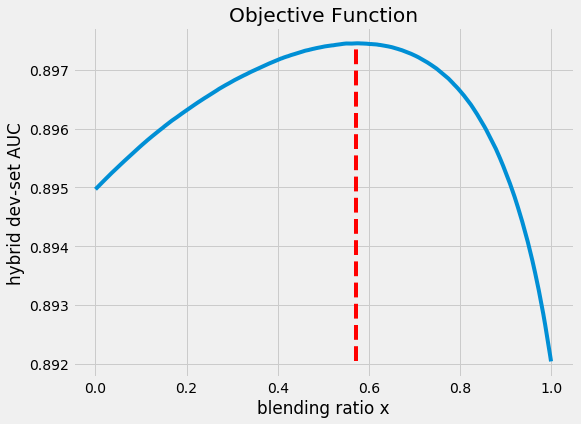

In [332]:
# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('blending ratio x'); plt.ylabel('hybrid dev-set AUC')
plt.vlines(maxx, min(results), max(results), linestyles = '--', colors = 'r')
plt.plot(x, results);

# Print out the minimum of the function and value
print('Maximum AUC of %0.4f occurs at %0.4f' % (maxy, maxx))

In [329]:
# optimized blending
optimized_blend = hybrid_prediction(df_nb, df_lgbm, weight1=maxx, filename='blend_optim_nb_lgbm1')
optimized_blend.tail()

ID_code    target
199995  test_199995  0.071686
199996  test_199996  0.015495
199997  test_199997  0.004673
199998  test_199998  0.124260
199999  test_199999  0.177643

- Score on official KAGGLE test set: __0.896__. 

#### Optimal Blending with Bayesian Optimization

In [333]:
def objective(xx):
    """Objective function to minimize"""
    
    Y_pred_hybrid = xx*Y_pred_dev_nb + (1-xx)*Y_pred_dev_lgbm
    auc_xx = roc_auc_score(test_labels, Y_pred_hybrid)
    
    loss = 1 - auc_xx
    
    return loss

In [334]:
# Create the domain space
space = hp.uniform('x', 0, 1)

# Create the algorithms
tpe_algo = tpe.suggest

# Create two trials objects
tpe_trials = Trials()

# Run optimization: 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

print(tpe_best)

100%|██████████| 2000/2000 [00:49<00:00, 27.67it/s, best loss: 0.10255180573061884]
{'x': 0.5744055276635118}


In [336]:
alpha_opt = tpe_best['x']
print('Optimal hybridization:', alpha_opt)
#print('Optimal loss:', objective(alpha_opt))
auc_opt = 1 - objective(alpha_opt)
print('Optimized AUC:', auc_opt)

Optimal hybridization: 0.5744055276635118
Optimized AUC: 0.8974481942693812


In [338]:
# Print out information about number of trials
print('Number of trials needed to attain optimum with TPE: {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))

Number of trials needed to attain optimum with TPE: 1868


In [339]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

iteration      loss         x
0          0  0.107762  0.996171
1          1  0.104070  0.860990
2          2  0.102974  0.747178
3          3  0.102810  0.407649
4          4  0.104972  0.007561

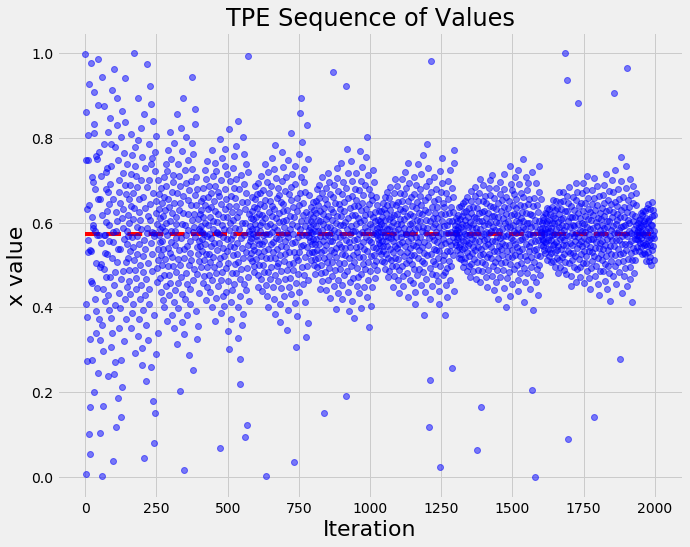

In [340]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(maxx, 0, 2000, linestyles = '--', colors = 'r');

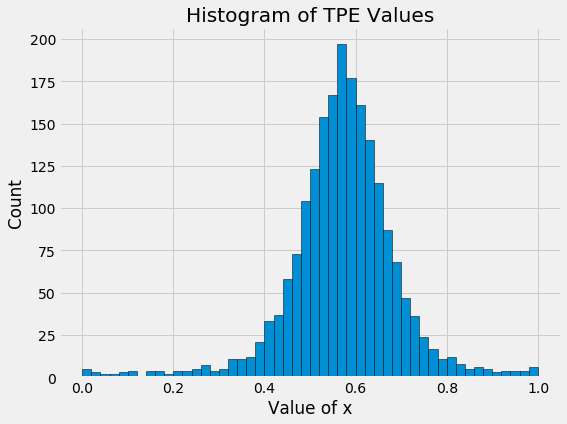

In [341]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

In [344]:
# optimized blending
optimized_blend2 = hybrid_prediction(df_nb, df_lgbm, weight1=alpha_opt, filename='blend_optim2_nb_lgbm1')
optimized_blend2.tail()

ID_code    target
199995  test_199995  0.071516
199996  test_199996  0.015475
199997  test_199997  0.004661
199998  test_199998  0.123938
199999  test_199999  0.177118

- Score on official KAGGLE test set: __0.896__.

### Simple Blending of Naive Bayes, LGBM, XGB 

In [13]:
# naive blending of NB, LGBM, XGB
naive_blend3 = hybrid_prediction3(df_nb, df_lgbm, df_xgb, weight1=1/3, filename='blend_simple_nb_lgbm1_xgb1')
naive_blend3.tail()

ID_code    target
199995  test_199995  0.060562
199996  test_199996  0.015245
199997  test_199997  0.005027
199998  test_199998  0.118757
199999  test_199999  0.162227

- Score on official KAGGLE test set: __0.896__. 
- No improvement as compared to blending NB with LGBM only. 
- Need to optimize XGB with HPO and add feature engineering.

-----

# ANOMALY DETECTION (AUTOENCODER)

This is __work in progress__. 

In [101]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   var_8   var_9  var_10   var_11   var_12   var_13  var_14  \
0  18.6266 -4.9200  5.7470  2.9252   3.1821  14.0137   0.5745  8.7989   
1  16.5338  3.1468  8.0851 -0.4032   8.0585  14.0239   8.4135  5.4345   
2  14.6155 -4.9193  5.9525 -0.3249 -11.2648  14.1929   7.3124  7.5244   
3  14.9250 -5.8609  8.2450  2.3061   2.8102  13.8463  11.9704  6.4569   
4  19.2514  6.2654  7.6784 -9.4458 -12.1419  13.8481   7.8895  7.7894   

    var_15   var_16   var_17   var_18   var_19   var_20   var_21   var_22  \
0  14.5691   5.7487  -7.2393   4.2840  30.7133  10.5350  16.2191   2.5791   
1  13.7003  13.8275 -15.5849   7.8000  28.5708   3.4287   2.7407   8.5524   
2  14.6472   7.6782  -1.7395   4.7011  20.4775  17.7559  18.1377   1.2145   
3  14.8372  10.7430  -0.4299  15.9426  13.7257  20.3010  12.5579   6.8202   
4  15.0553   8.4871  -3.0680   6.5263  11.3152  21.4246  18.9608  10.1102   

   var_23   var_24   var_25   var_26  var_27  var_28  var_29   var_30  \
0  2.4716  14.3831  13.4325  -5.1488 -0.4073  4.9306  5.9965  -0.3085   
1  3.3716   6.9779  13.8910 -11.7684 -2.5586  5.0464  0.5481  -9.2987   
2  3.5137   5.6777  13.2177  -7.9940 -2.9029  5.8463  6.1439 -11.1025   
3  2.7229  12.1354  13.7367   0.8135 -0.9059  5.9070  2.8407 -15.2398   
4  2.7142  14.2080  13.5433   3.1736 -3.3423  5.9015  7.9352  -3.1582   

    var_31  var_32   var_33   var_34   var_35  var_36  var_37   var_38  \
0  12.9041 -3.8766  16.8911  11.1920  10.5785  0.6764  7.8871   4.6667   
1   7.8755  1.2859  19.3710  11.3702   0.7399  2.7995  5.8434  10.8160   
2  12.4858 -2.2871  19.0422  11.0449   4.1087  4.6974  6.9346  10.8917   
3  10.4407 -2.5731   6.1796  10.6093  -5.9158  8.1723  2.8521   9.1738   
4   9.4668 -0.0083  19.3239  12.4057   0.6329  2.7922  5.8184  19.3038   

   var_39   var_40   var_41   var_42   var_43   var_44   var_45   var_46  \
0  3.8743  -5.2387   7.3746  11.5767  12.0446  11.6418  -7.0170   5.9226   
1  3.6783 -11.1147   1.8730   9.8775  11.7842   1.2444 -47.3797   7.3718   
2  0.9003 -13.5174   2.2439  11.5283  12.0406   4.1006  -7.9078  11.1405   
3  0.6665  -3.8294  -1.0370  11.7770  11.2834   8.0485 -24.6840  12.7404   
4  1.4450  -5.5963  14.0685  11.9171  11.5111   6.9087 -65.4863  13.8657   

    var_47   var_48   var_49   var_50   var_51  var_52  var_53  var_54  \
0 -14.2136  16.0283   5.3253  12.9194  29.0460 -0.6940  5.1736 -0.7474   
1   0.1948  34.4014  25.7037  11.8343  13.2256 -4.1083  6.6885 -8.0946   
2  -5.7864  20.7477   6.8874  12.9143  19.5856  0.7268  6.4059  9.3124   
3 -35.1659   0.7613   8.3838  12.6832   9.5503  1.7895  5.2091  8.0913   
4   0.0444  -0.1346  14.4268  13.3273  10.4857 -1.4367  5.7555 -8.5414   

    var_55   var_56  var_57  var_58   var_59   var_60   var_61  var_62  \
0  14.8322  11.2668  5.3822  2.0183  10.1166  16.1828   4.9590  2.0771   
1  18.5995  19.3219  7.0118  1.9210   8.8682   8.0109  -7.2417  1.7944   
2   6.2846  15.6372  5.8200  1.1000   9.1854  12.5963 -10.3734  0.8748   
3  12.3972  14.4698  6.5850  3.3164   9.4638  15.7820 -25.0222  3.4418   
4  14.1482  16.9840  6.1812  1.9548   9.2048   8.6591 -27.7439 -0.4952   

   var_63  var_64  var_65  var_66   var_67  var_68  var_69   var_70  var_71  \
0 -0.2154  8.6748  9.5319  5.8056  22.4321  5.0109 -4.7010  21.6374  0.5663   
1 -1.3147  8.1042  1.5365  5.4007   7.9344  5.0220  2.2302  40.5632  0.5134   
2  5.8042  3.7163 -1.1016  7.3667   9.8565  5.0228 -5.7828   2.3612  0.8520   
3 -4.3923  8.6464  6.3072  5.6221  23.6143  5.0220 -3.9989   4.0462

In [112]:
# split normalized train data into train and dev set
X_train_ae, X_dev_ae = train_test_split(train_norm.set_index(['ID_code']), test_size=0.2, random_state=123)
# for training the autoencoder in anomly-dtection frameworo only consider majority class 0
X_train_ae = X_train_ae[X_train_ae['target']==0]
X_train_ae = X_train_ae.drop(['target'], axis=1)

y_dev_ae = X_dev_ae['target']
X_dev_ae = X_dev_ae.drop(['target'], axis=1)

## AUTOENCODER: Training and Evaluation

In [114]:
# define input shape and encoding dimension
input_dim = X_train_ae.shape[1]
encoding_dim = 100

In [116]:
### define autoencoder
input_layer = Input(shape=(input_dim, ))

# encoder
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)

# decoder
decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

- Train our model for 100 epochs with a batch size of 32 samples. 
- Save the best performing model to a file, using ModelCheckpoint provided by Keras. 
- Additionally, the training progress will be exported in a format that TensorBoard understands.

In [124]:
### TRAINING
nb_epoch = 20
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train_ae, X_train_ae,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_dev_ae, X_dev_ae),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Train on 143987 samples, validate on 40000 samples
Epoch 1/20
143987/143987 [==============================] - 11s 79us/step - loss: 0.8962 - acc: 0.1227 - val_loss: 0.9079 - val_acc: 0.1208
Epoch 2/20
143987/143987 [==============================] - 11s 80us/step - loss: 0.8962 - acc: 0.1241 - val_loss: 0.9084 - val_acc: 0.1217
Epoch 3/20
143987/143987 [==============================] - 11s 76us/step - loss: 0.8962 - acc: 0.1238 - val_loss: 0.9081 - val_acc: 0.1217
Epoch 4/20
143987/143987 [==============================] - 11s 74us/step - loss: 0.8962 - acc: 0.1245 - val_loss: 0.9083 - val_acc: 0.1150
Epoch 5/20
143987/143987 [==============================] - 11s 74us/step - loss: 0.8962 - acc: 0.1234 - val_loss: 0.9084 - val_acc: 0.1147
Epoch 6/20
143987/143987 [==============================] - 12s 83us/step - loss: 0.8962 - acc: 0.1236 - val_loss: 0.9085 - val_acc: 0.1196
Epoch 7/20
143987/143987 [==============================] - 13s 87us/step - loss: 0.8962 - acc: 0.1238 - val_

In [ ]:
autoencoder = load_model('model.h5')

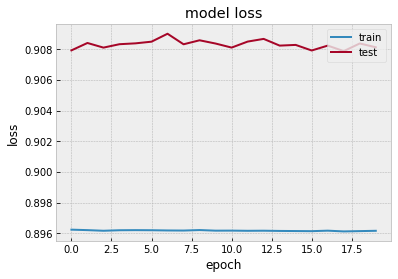

In [125]:
### EVALUATION
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [126]:
# predictions on dev set
predictions = autoencoder.predict(X_dev_ae)
mse = np.mean(np.power(X_dev_ae - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_dev_ae})
error_df.describe()

reconstruction_error    true_class
count          40000.000000  40000.000000
mean               0.883214      0.102125
std                0.087277      0.302816
min                0.541871      0.000000
25%                0.823297      0.000000
50%                0.880045      0.000000
75%                0.939790      0.000000
max                1.317189      1.000000

In [129]:
error_df.head()

reconstruction_error  true_class
ID_code                                       
train_169119              0.960468           0
train_33832               0.972707           0
train_117948              0.923139           0
train_78859               0.791983           1
train_159686              0.897867           0

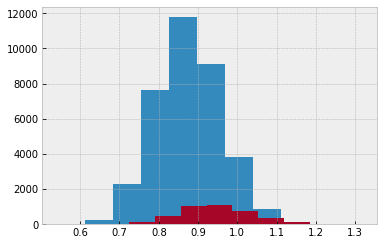

In [154]:
plt.hist(error_df.loc[error_df['true_class']==0]['reconstruction_error'].values);
plt.hist(error_df.loc[error_df['true_class']==1]['reconstruction_error'].values);

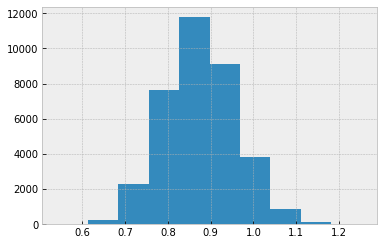

In [132]:
# PLOT: Reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
#normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

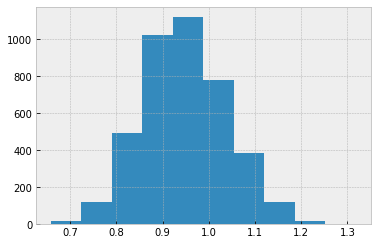

In [133]:
# PLOT: Reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

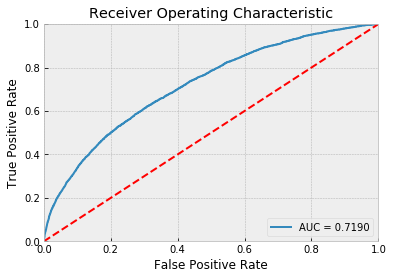

In [134]:
# PLOT: Roc curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

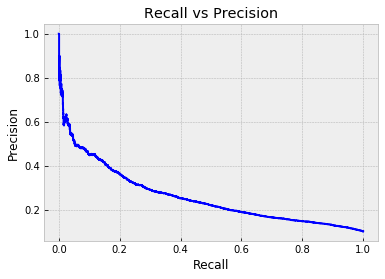

In [137]:
# PLOT: precision-recall curve
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

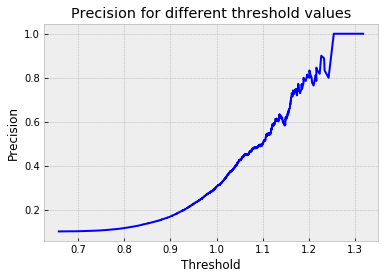

In [138]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

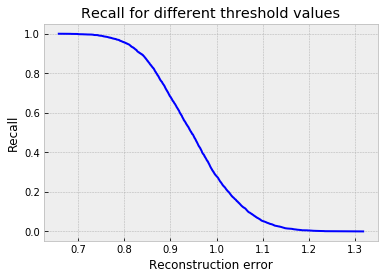

In [139]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

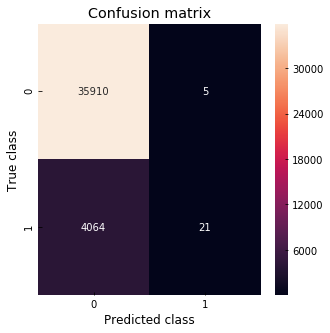

In [160]:
threshold = 1.2
LABELS = ["0", "1"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()